# 정당 분석

In [60]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
import datetime
%matplotlib inline

In [61]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [62]:
gender_total = pd.read_csv('whole-gender-bill-1320.csv', index_col=0,
                           parse_dates=['제안일자','의결일자'],encoding='utf-8-sig')
print(gender_total.shape)
gender_total.head(1)

(4295, 16)


의안번호         의안명       제안일자 제안자구분       의결일자  의결결과  \
0  131131  소득세법중개정법률안 1990-12-17   위원장 1990-12-18  원안가결   

                     제안회기                                               제안이유  \
0  제13대 (1988~1992) 제151회     정부제출,柳인학·강金식·금봉욱·林춘원·李경재·허만기·홍영기의원외64인 발의,1...   

   소관위원회 제안자  발의자 제안정당   성별  여성의원 수 정당성향  국회회기  
0  재무위원회  []  위원장  위원장  NaN       0  NaN    13

In [63]:
gender_total['제안일자'] = gender_total['제안일자'].dt.date
gender_total['의결일자'] = gender_total['의결일자'].dt.date

In [64]:
gender_total['제안일자'].unique()

array([datetime.date(1990, 12, 17), datetime.date(1990, 11, 20),
       datetime.date(1990, 10, 8), ..., datetime.date(2016, 6, 1),
       datetime.date(2016, 5, 31), datetime.date(2016, 5, 30)],
      dtype=object)

## 정부안 탐색

In [65]:
gender_total['제안자구분'].value_counts()

의원     3766
위원장     345
정부      184
Name: 제안자구분, dtype: int64

## 전체 진보/보수 성향별 wordcloud

In [74]:
gender = gender_total[gender_total['제안자구분'] == '의원']

In [75]:
gender['정당성향'].value_counts()

진보    2152
보수    1558
Name: 정당성향, dtype: int64

In [76]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자',
            '조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출']

    text = [word for word in text if word not in stopwords]
    return text

In [77]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

<ipython-input-77-e0a34b6ee1ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
<ipython-input-77-e0a34b6ee1ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())


In [78]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 219 ms, sys: 3.79 ms, total: 223 ms
Wall time: 223 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [80]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 2min 14s, sys: 1.27 s, total: 2min 15s
Wall time: 2min 2s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2    [유아의보호, 교육에관한법률안, 현대사회, 산업화, 여성, 사회참여, 가족구조, 핵...
3    [특정강력범죄의처벌에관한특례법안, 반인륜, 반사회적, 흉악범죄, 가정, 사회질서, ...
6    [지방선거법안, 지방의회의원, 지방자치단체, 주민, 선출, 지방자치, 이념, 구현,...
Name: tokens, dtype: object

In [81]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 1.18 s, sys: 17.9 ms, total: 1.2 s
Wall time: 1.26 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 2.89 ms, sys: 1.36 ms, total: 4.25 ms
Wall time: 5.36 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
# 명사 수가 10개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(3761, 19)


### 진보/보수 model

In [84]:
progressive = gender[gender['정당성향'] == '진보']
conservative = gender[gender['정당성향'] == '보수']

In [85]:
print(progressive.shape)
print(conservative.shape)

(2151, 19)
(1554, 19)


In [86]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [87]:
model_progressive = Word2Vec(progressive['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)
model_conservative = Word2Vec(conservative['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-10-11 09:20:02,962 : INFO : collecting all words and their counts
2020-10-11 09:20:02,963 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-11 09:20:03,006 : INFO : collected 16275 word types from a corpus of 160566 raw words and 2151 sentences
2020-10-11 09:20:03,007 : INFO : Loading a fresh vocabulary
2020-10-11 09:20:03,040 : INFO : effective_min_count=10 retains 2463 unique words (15% of original 16275, drops 13812)
2020-10-11 09:20:03,046 : INFO : effective_min_count=10 leaves 128933 word corpus (80% of original 160566, drops 31633)
2020-10-11 09:20:03,068 : INFO : deleting the raw counts dictionary of 16275 items
2020-10-11 09:20:03,069 : INFO : sample=0.001 downsamples 44 most-common words
2020-10-11 09:20:03,070 : INFO : downsampling leaves estimated 117905 word corpus (91.4% of prior 128933)
2020-10-11 09:20:03,083 : INFO : estimated required memory for 2463 words and 100 dimensions: 3201900 bytes
2020-10-11 09:20:03,087 : INFO : resetting

2020-10-11 09:20:05,417 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:05,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:05,429 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:05,430 : INFO : EPOCH - 15 : training on 160566 raw words (117963 effective words) took 0.1s, 1039152 effective words/s
2020-10-11 09:20:05,534 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:05,536 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:05,542 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:05,546 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:05,547 : INFO : EPOCH - 16 : training on 160566 raw words (117923 effective words) took 0.1s, 1069068 effective words/s
2020-10-11 09:20:05,640 : INFO : worker thread finished; awaiting finish of 3 more thread

2020-10-11 09:20:07,254 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:07,255 : INFO : EPOCH - 31 : training on 160566 raw words (117909 effective words) took 0.1s, 1085809 effective words/s
2020-10-11 09:20:07,350 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:07,356 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:07,361 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:07,365 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:07,365 : INFO : EPOCH - 32 : training on 160566 raw words (118052 effective words) took 0.1s, 1118929 effective words/s
2020-10-11 09:20:07,463 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:07,466 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:07,472 : INFO : worker thread finished; awaiting finish of 1 more thread

2020-10-11 09:20:09,288 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:09,289 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:09,293 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:09,298 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:09,299 : INFO : EPOCH - 48 : training on 160566 raw words (117861 effective words) took 0.1s, 1148628 effective words/s
2020-10-11 09:20:09,406 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:09,414 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:09,417 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:09,422 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:09,423 : INFO : EPOCH - 49 : training on 160566 raw words (117904 effective words) took 0.1s, 1008273 effective words/

2020-10-11 09:20:11,076 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:11,082 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:11,083 : INFO : EPOCH - 64 : training on 160566 raw words (118033 effective words) took 0.1s, 1031322 effective words/s
2020-10-11 09:20:11,190 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:11,194 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:11,199 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:11,202 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:11,204 : INFO : EPOCH - 65 : training on 160566 raw words (117850 effective words) took 0.1s, 1020663 effective words/s
2020-10-11 09:20:11,301 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:11,303 : INFO : worker thread finished; awaiting finish of 2 more thread

2020-10-11 09:20:12,950 : INFO : EPOCH - 80 : training on 160566 raw words (117922 effective words) took 0.1s, 984721 effective words/s
2020-10-11 09:20:13,051 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:13,052 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:13,058 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:13,062 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:13,064 : INFO : EPOCH - 81 : training on 160566 raw words (117828 effective words) took 0.1s, 1088756 effective words/s
2020-10-11 09:20:13,153 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:13,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:13,157 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:13,164 : INFO : worker thread finished; awaiting finish of 0 more threads

2020-10-11 09:20:14,889 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:14,893 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:14,899 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:14,899 : INFO : EPOCH - 97 : training on 160566 raw words (117936 effective words) took 0.1s, 1039334 effective words/s
2020-10-11 09:20:15,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:15,007 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:15,010 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:15,017 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:15,018 : INFO : EPOCH - 98 : training on 160566 raw words (117871 effective words) took 0.1s, 1030830 effective words/s
2020-10-11 09:20:15,104 : INFO : worker thread finished; awaiting finish of 3 more thread

2020-10-11 09:20:16,913 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:16,917 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:16,921 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:16,922 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:16,924 : INFO : EPOCH - 11 : training on 116262 raw words (79857 effective words) took 0.1s, 1036903 effective words/s
2020-10-11 09:20:16,989 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:16,993 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:16,996 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:16,997 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:16,998 : INFO : EPOCH - 12 : training on 116262 raw words (79891 effective words) took 0.1s, 1131296 effective words/s


2020-10-11 09:20:18,214 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:18,215 : INFO : EPOCH - 27 : training on 116262 raw words (79954 effective words) took 0.1s, 1043874 effective words/s
2020-10-11 09:20:18,291 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:18,300 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:18,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:18,307 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:18,308 : INFO : EPOCH - 28 : training on 116262 raw words (79890 effective words) took 0.1s, 914860 effective words/s
2020-10-11 09:20:18,378 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:18,380 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:18,385 : INFO : worker thread finished; awaiting finish of 1 more threads
2

2020-10-11 09:20:19,677 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:19,681 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:19,686 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:19,689 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:19,691 : INFO : EPOCH - 44 : training on 116262 raw words (79816 effective words) took 0.1s, 1000716 effective words/s
2020-10-11 09:20:19,760 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:19,767 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:19,771 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:19,773 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:19,773 : INFO : EPOCH - 45 : training on 116262 raw words (79816 effective words) took 0.1s, 1021095 effective words/s


2020-10-11 09:20:21,014 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:21,016 : INFO : EPOCH - 60 : training on 116262 raw words (79943 effective words) took 0.1s, 1022775 effective words/s
2020-10-11 09:20:21,087 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:21,092 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:21,095 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:21,096 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:21,097 : INFO : EPOCH - 61 : training on 116262 raw words (79943 effective words) took 0.1s, 1088247 effective words/s
2020-10-11 09:20:21,165 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:21,166 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:21,171 : INFO : worker thread finished; awaiting finish of 1 more threads


2020-10-11 09:20:22,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:22,351 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:22,355 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:22,356 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:22,357 : INFO : EPOCH - 77 : training on 116262 raw words (79989 effective words) took 0.1s, 1109031 effective words/s
2020-10-11 09:20:22,438 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:22,439 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:22,445 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:22,449 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:22,451 : INFO : EPOCH - 78 : training on 116262 raw words (79876 effective words) took 0.1s, 899935 effective words/s
2

2020-10-11 09:20:23,697 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:23,698 : INFO : EPOCH - 93 : training on 116262 raw words (79961 effective words) took 0.1s, 963792 effective words/s
2020-10-11 09:20:23,769 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:23,770 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:23,772 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-10-11 09:20:23,773 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-10-11 09:20:23,774 : INFO : EPOCH - 94 : training on 116262 raw words (79860 effective words) took 0.1s, 1175613 effective words/s
2020-10-11 09:20:23,848 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-10-11 09:20:23,850 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-10-11 09:20:23,855 : INFO : worker thread finished; awaiting finish of 1 more threads
2

In [88]:
print(model_progressive.wv.most_similar('여성'))
print(model_conservative.wv.most_similar('여성'))

2020-10-11 09:20:48,434 : INFO : precomputing L2-norms of word weight vectors
2020-10-11 09:20:48,446 : INFO : precomputing L2-norms of word weight vectors


[('참여율', 0.5155847072601318), ('정치참여', 0.4761829972267151), ('저조한', 0.43351465463638306), ('경제활동', 0.4278106093406677), ('성차별적', 0.4145926237106323), ('격차', 0.4095878601074219), ('경제활동참가율', 0.4085642099380493), ('비율', 0.3967439830303192), ('임금격차', 0.39646244049072266), ('회원국', 0.3952336013317108)]
[('사회참여', 0.5022814273834229), ('육아', 0.44076013565063477), ('사회활동', 0.4319390654563904), ('여성들', 0.42726290225982666), ('유산', 0.3756912052631378), ('경제활동', 0.36021220684051514), ('고용률', 0.3582070469856262), ('영역', 0.3473259508609772), ('가족친화적', 0.3357608914375305), ('모유수유', 0.3314210772514343)]


In [89]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs, model):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [90]:
progressive['문장벡터'] = progressive['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_progressive))
conservative['문장벡터'] = conservative['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_conservative))

<ipython-input-90-7f57b9f27847>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  progressive['문장벡터'] = progressive['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_progressive))
<ipython-input-90-7f57b9f27847>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conservative['문장벡터'] = conservative['tokens'].apply(lambda x: get_sentence_mean_vector(x, model_conservative))


In [91]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [92]:
progressive_word = total_tokens(progressive['tokens'])
conservative_word = total_tokens(conservative['tokens'])

In [95]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설','한편','문제','지급','제공','항제','사용','근거','대상',
            '이유','증가','제도','사업','정책','우리나라','행위','특례법','불구','수준','추가','관리','확보','의무','업무']
progressive_word = [each_word for each_word in progressive_word if each_word not in stopwords]
conservative_word = [each_word for each_word in conservative_word if each_word not in stopwords]

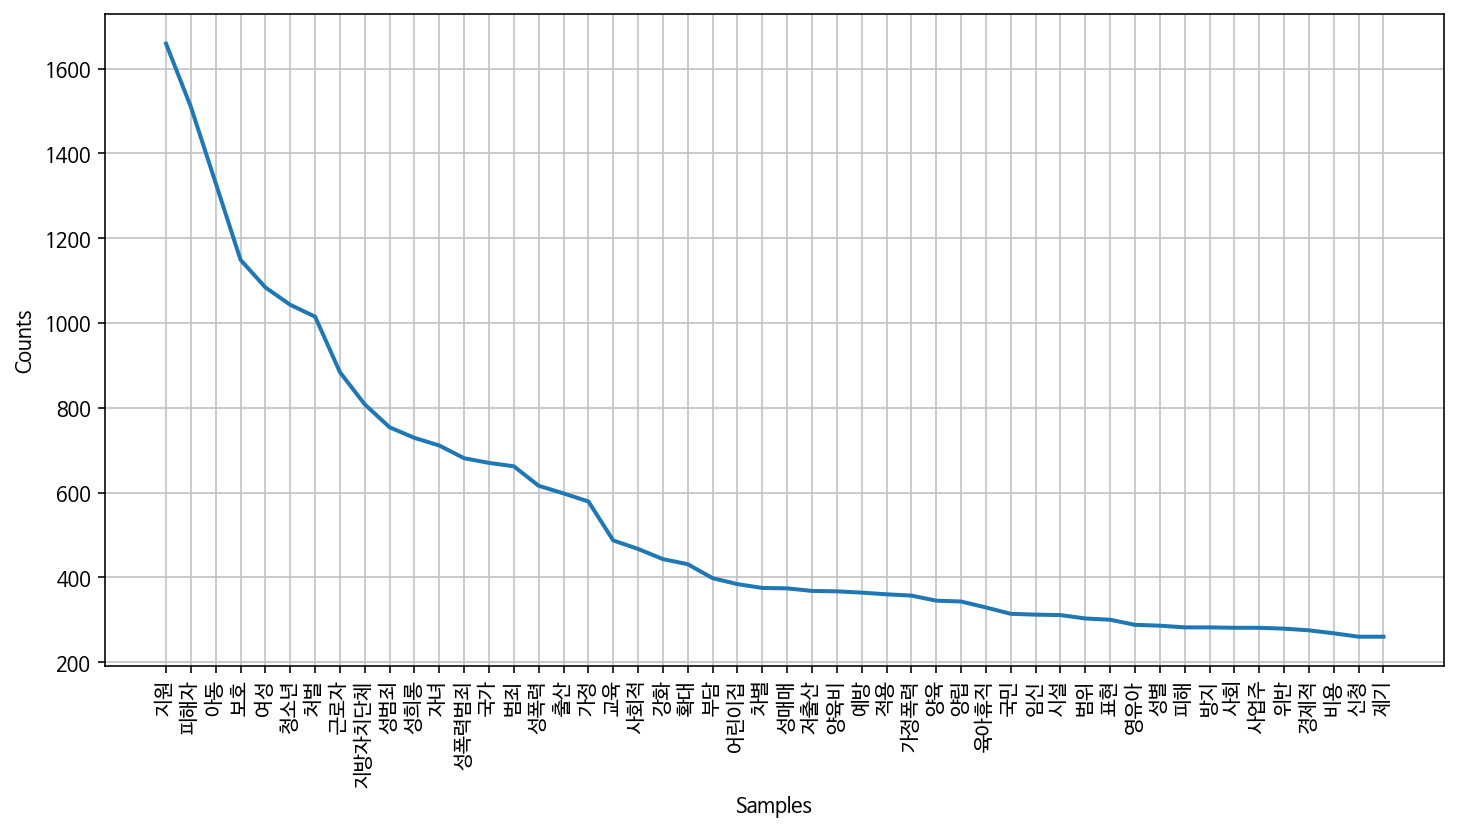

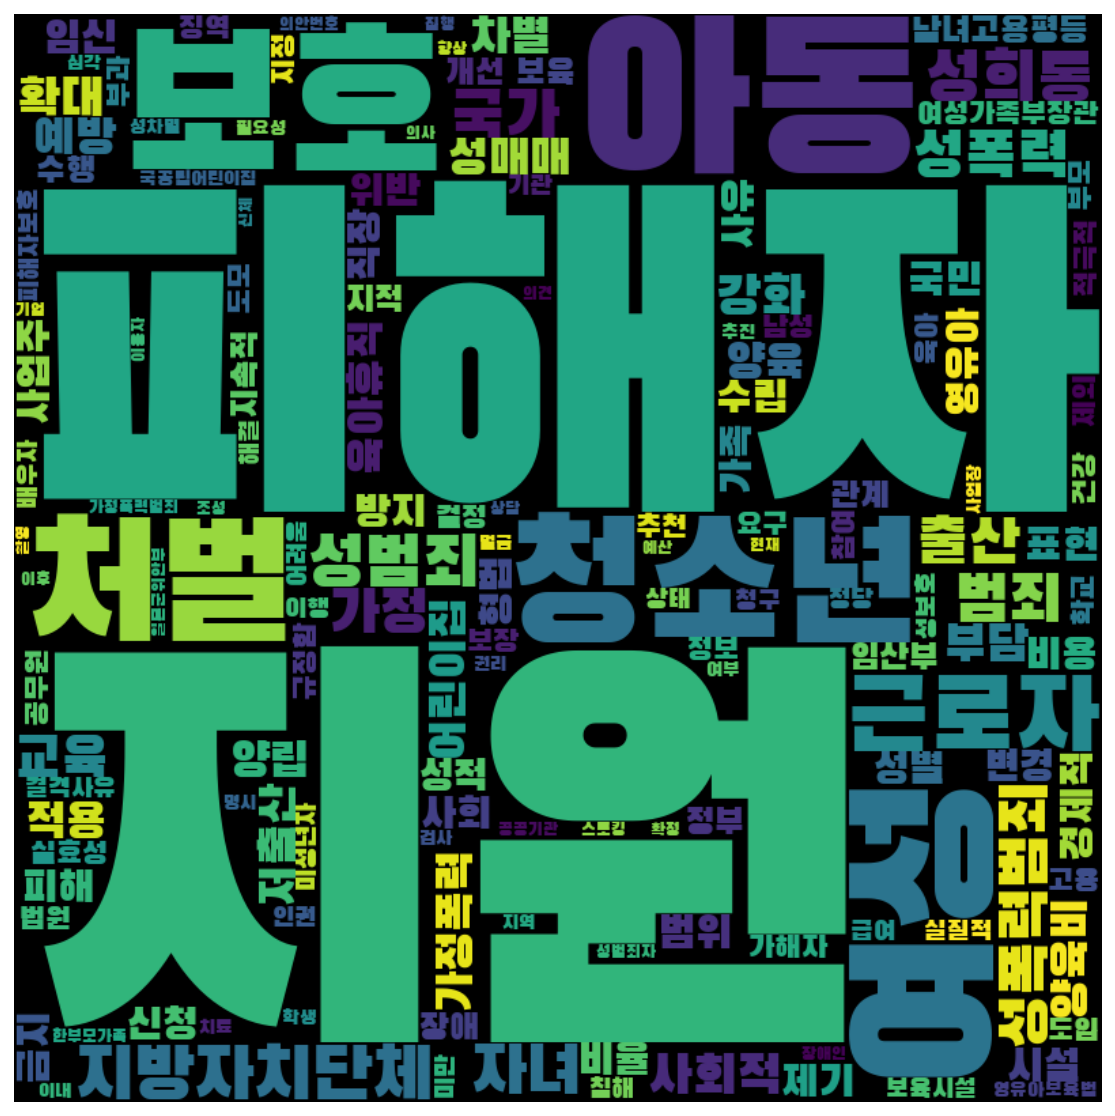

In [94]:
frewords_vis(progressive_word)
wordcloud_vis(progressive_word)

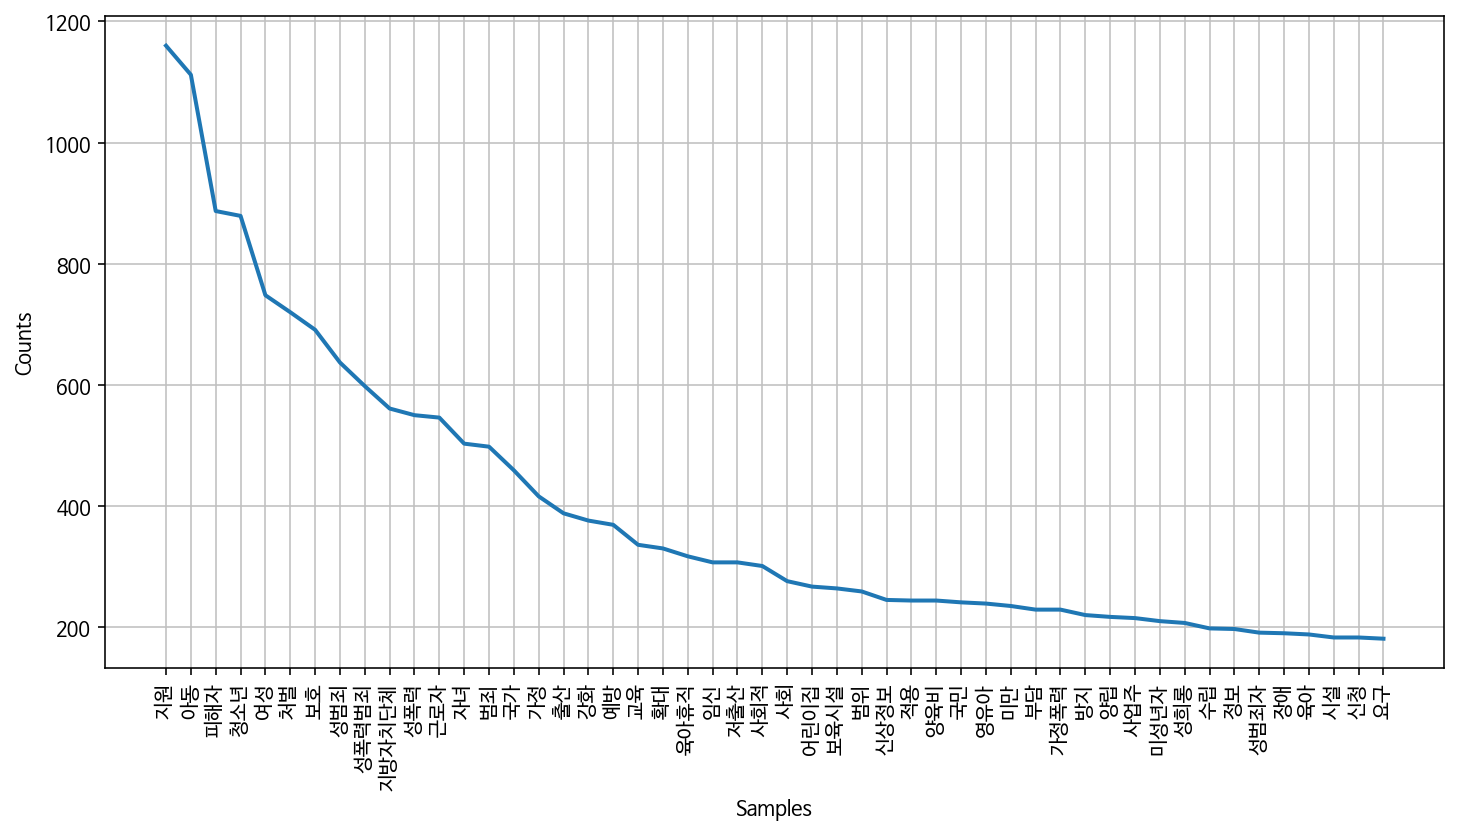

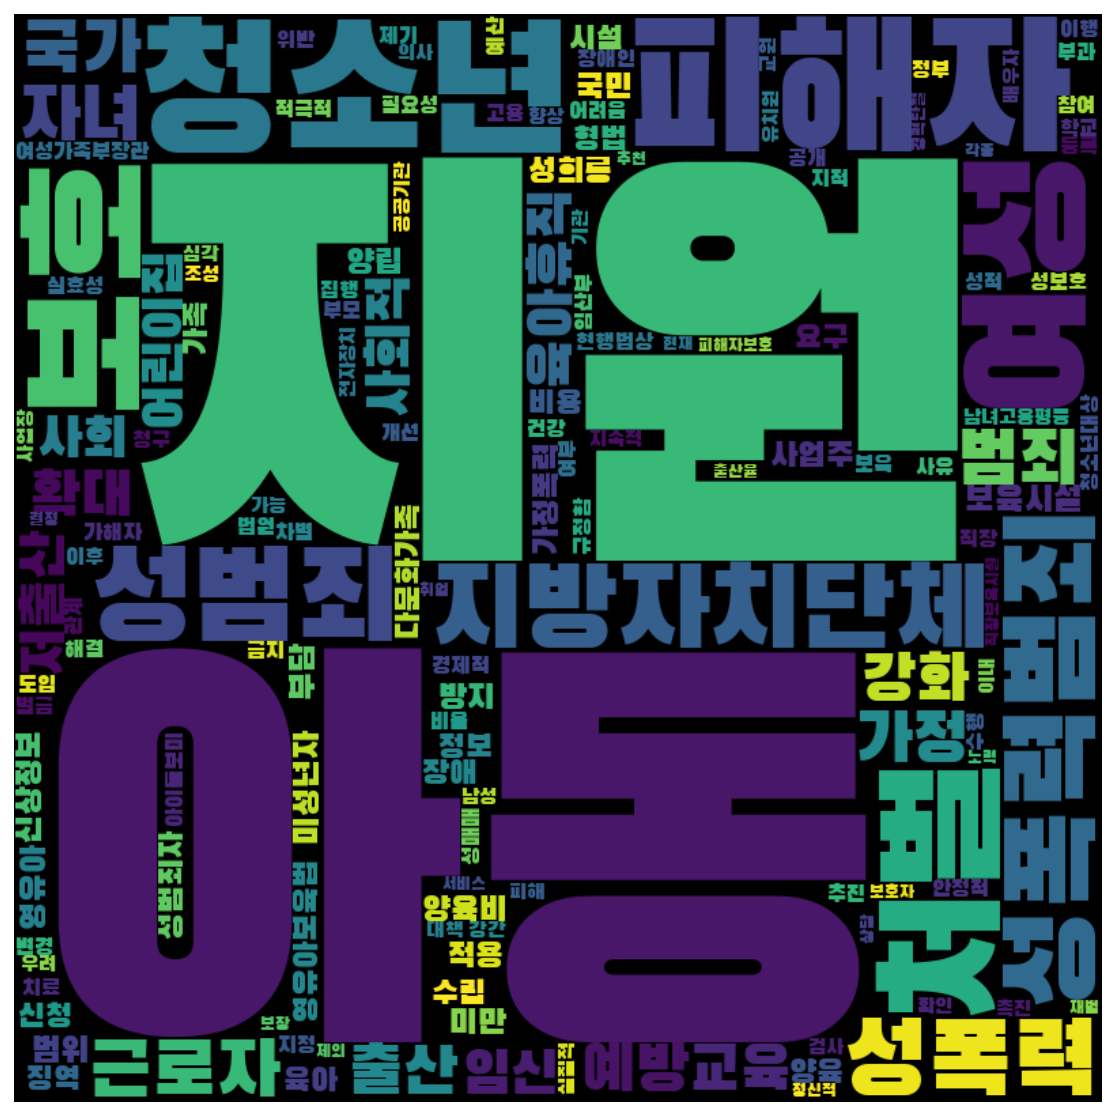

In [96]:
frewords_vis(conservative_word)
wordcloud_vis(conservative_word)

## 진보 k-means

엘보우: 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]


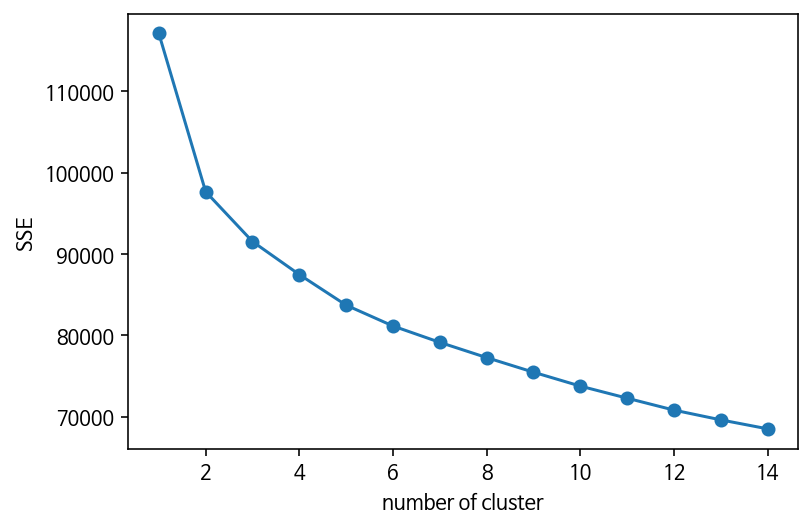

In [97]:
word_vectors_pro = progressive['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors_pro)

In [99]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


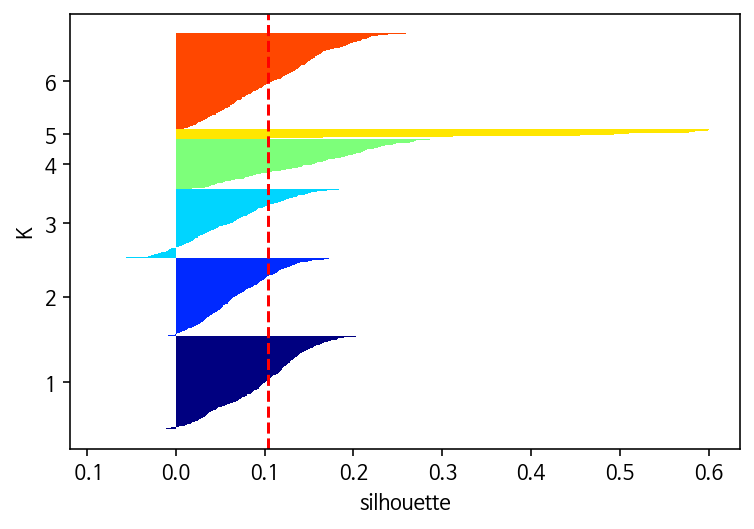

In [100]:
word_vectors_pro = progressive['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors_pro)
plotSilhouette(word_vectors_pro, y_km)

In [101]:
# K means 수행 
word_vectors_pro = progressive['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors_pro)
progressive['category'] = idx

<ipython-input-101-b83bfee9be13>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  progressive['category'] = idx


In [102]:
progressive['category'].value_counts()

4    523
0    519
2    420
1    396
3    250
5     43
Name: category, dtype: int64

In [103]:
progressive_g1 = progressive[progressive['category'] == 0]
progressive_g2 = progressive[progressive['category'] == 1]
progressive_g3 = progressive[progressive['category'] == 2]
progressive_g4 = progressive[progressive['category'] == 3]
progressive_g5 = progressive[progressive['category'] == 4]
progressive_g6 = progressive[progressive['category'] == 5]

In [104]:
progressive_g1_tokens = total_tokens(progressive_g1['tokens'])
progressive_g2_tokens = total_tokens(progressive_g2['tokens'])
progressive_g3_tokens = total_tokens(progressive_g3['tokens'])
progressive_g4_tokens = total_tokens(progressive_g4['tokens'])
progressive_g5_tokens = total_tokens(progressive_g5['tokens'])
progressive_g6_tokens = total_tokens(progressive_g6['tokens'])

In [105]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출',
            '신설','대상','문제','제공','항제','사용','근거','불구','범위','이유','증가']
progressive_g1_tokens = [each_word for each_word in progressive_g1_tokens if each_word not in stopwords]
progressive_g2_tokens = [each_word for each_word in progressive_g2_tokens if each_word not in stopwords]
progressive_g3_tokens = [each_word for each_word in progressive_g3_tokens if each_word not in stopwords]
progressive_g4_tokens = [each_word for each_word in progressive_g4_tokens if each_word not in stopwords]
progressive_g5_tokens = [each_word for each_word in progressive_g5_tokens if each_word not in stopwords]
progressive_g6_tokens = [each_word for each_word in progressive_g6_tokens if each_word not in stopwords]

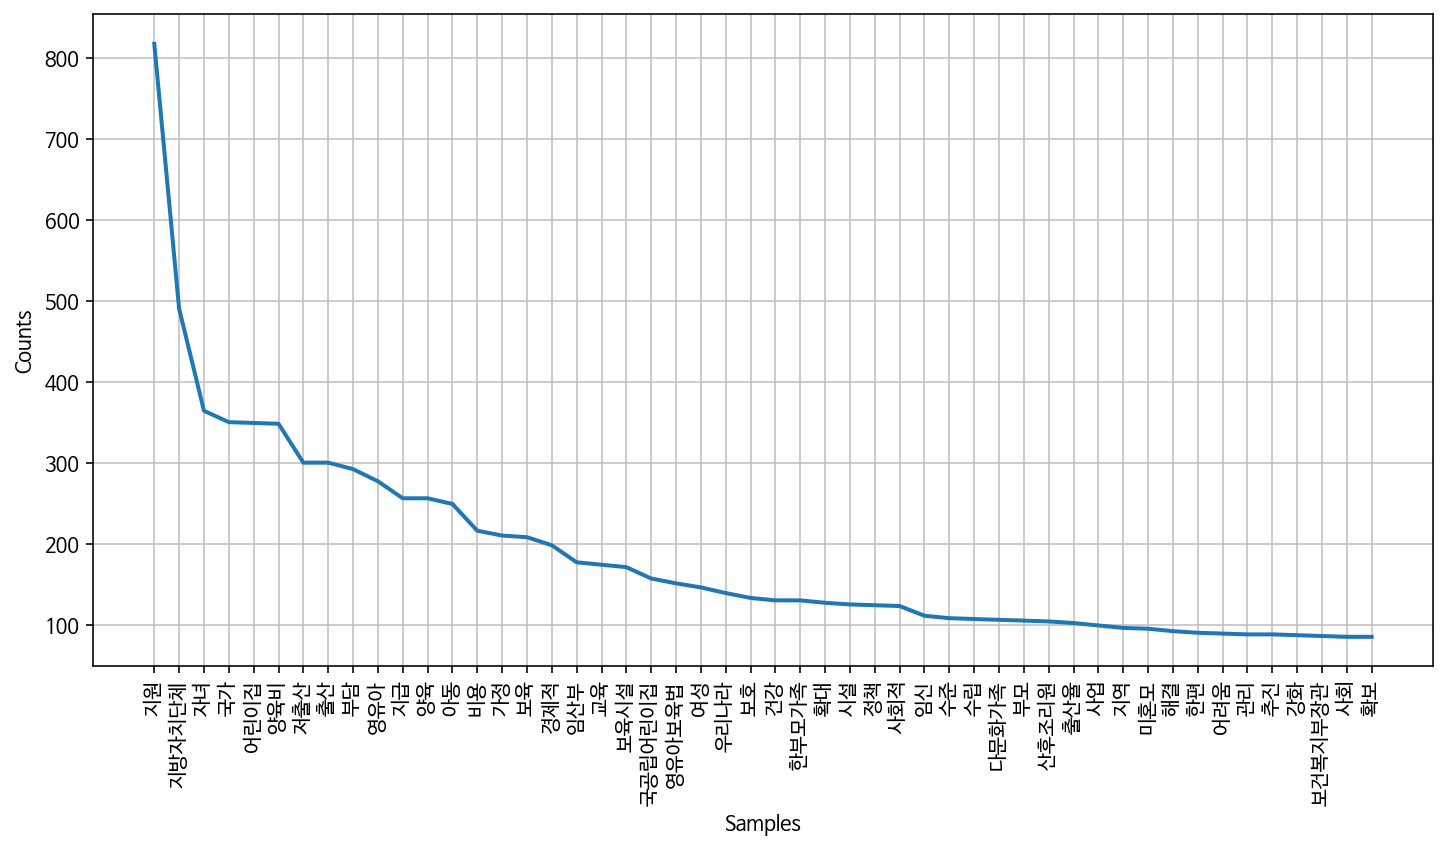

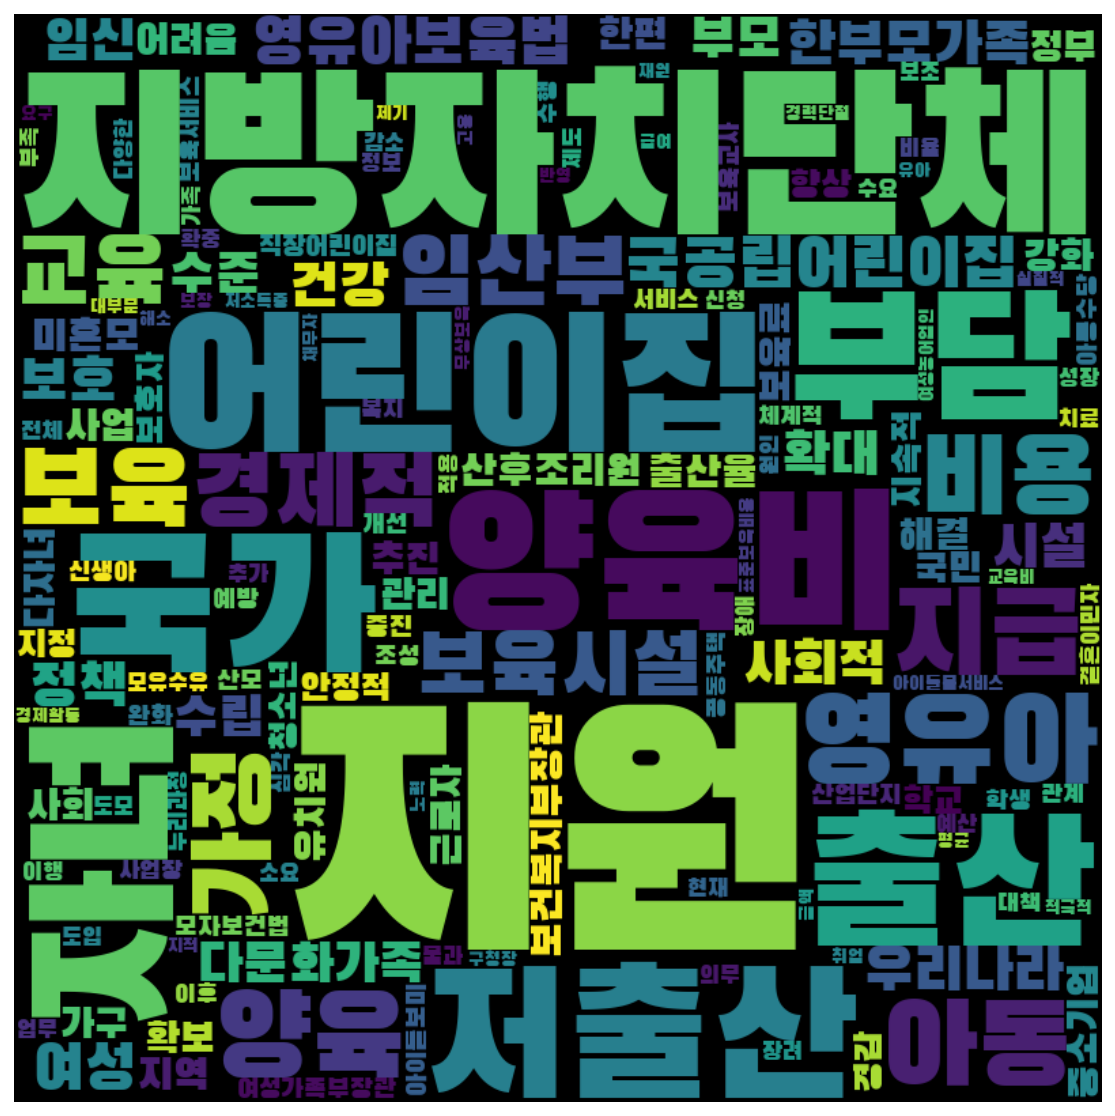

In [106]:
frewords_vis(progressive_g1_tokens)
wordcloud_vis(progressive_g1_tokens)

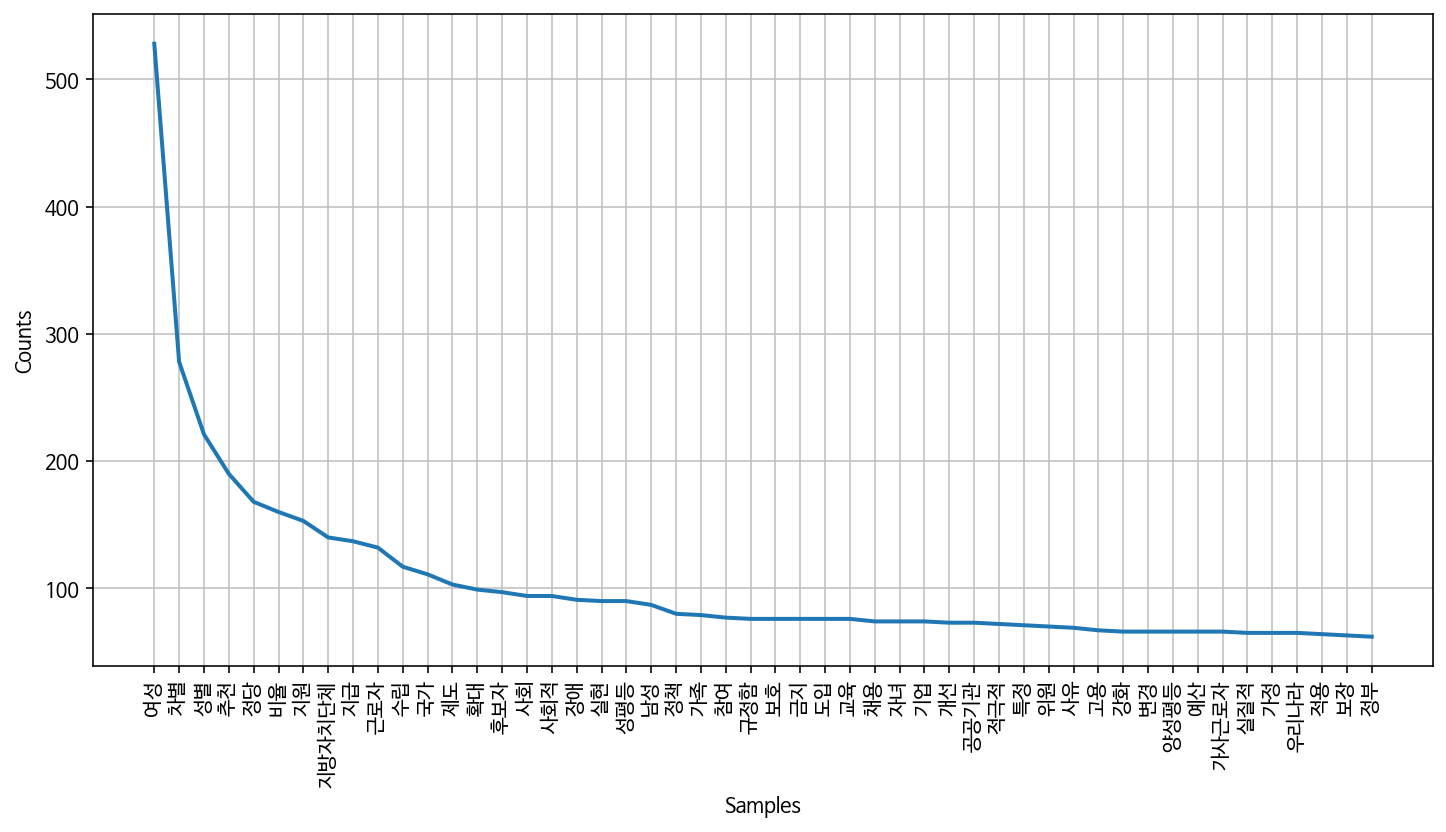

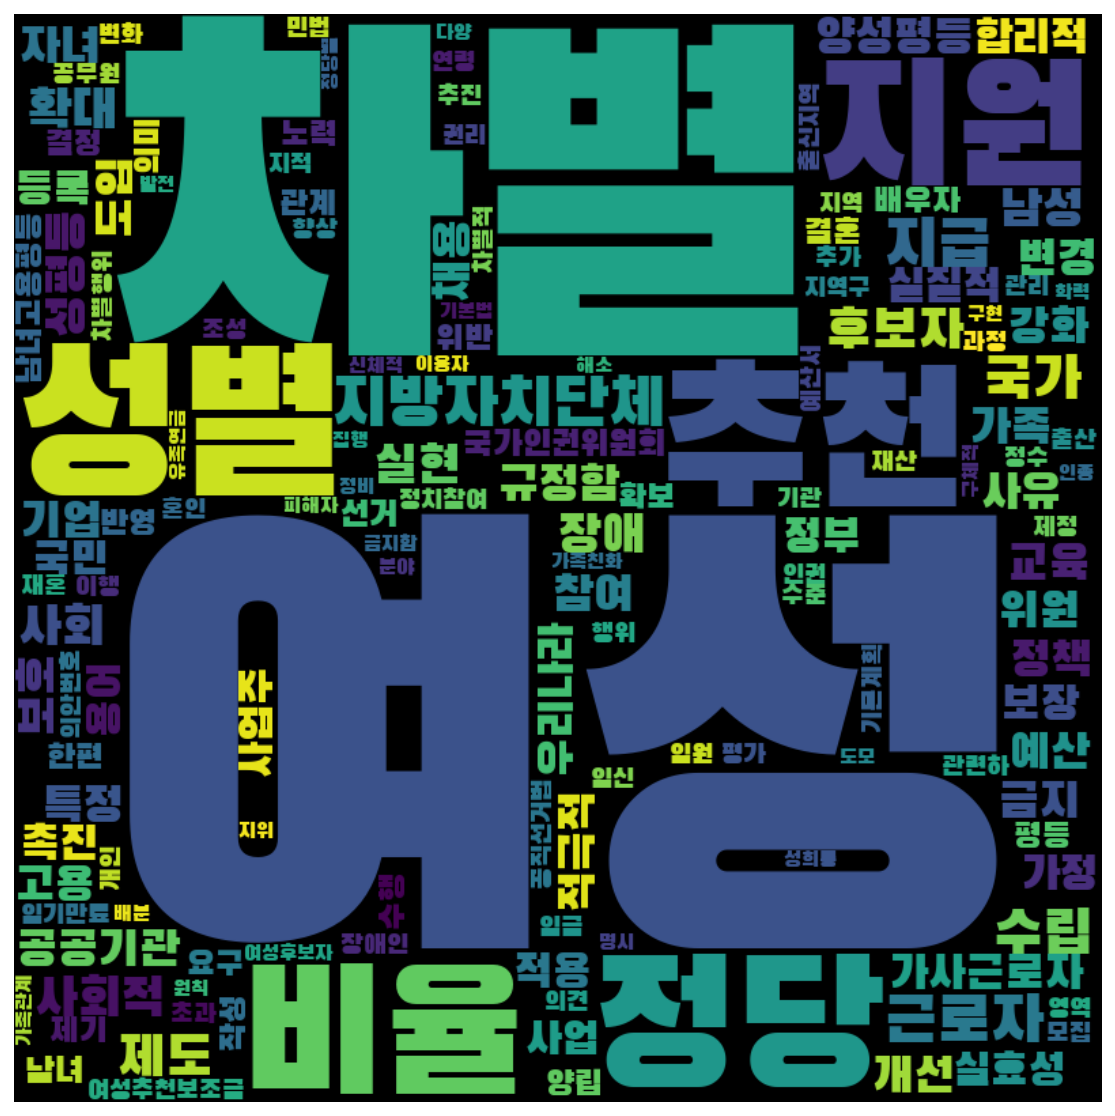

In [107]:
frewords_vis(progressive_g2_tokens)
wordcloud_vis(progressive_g2_tokens)

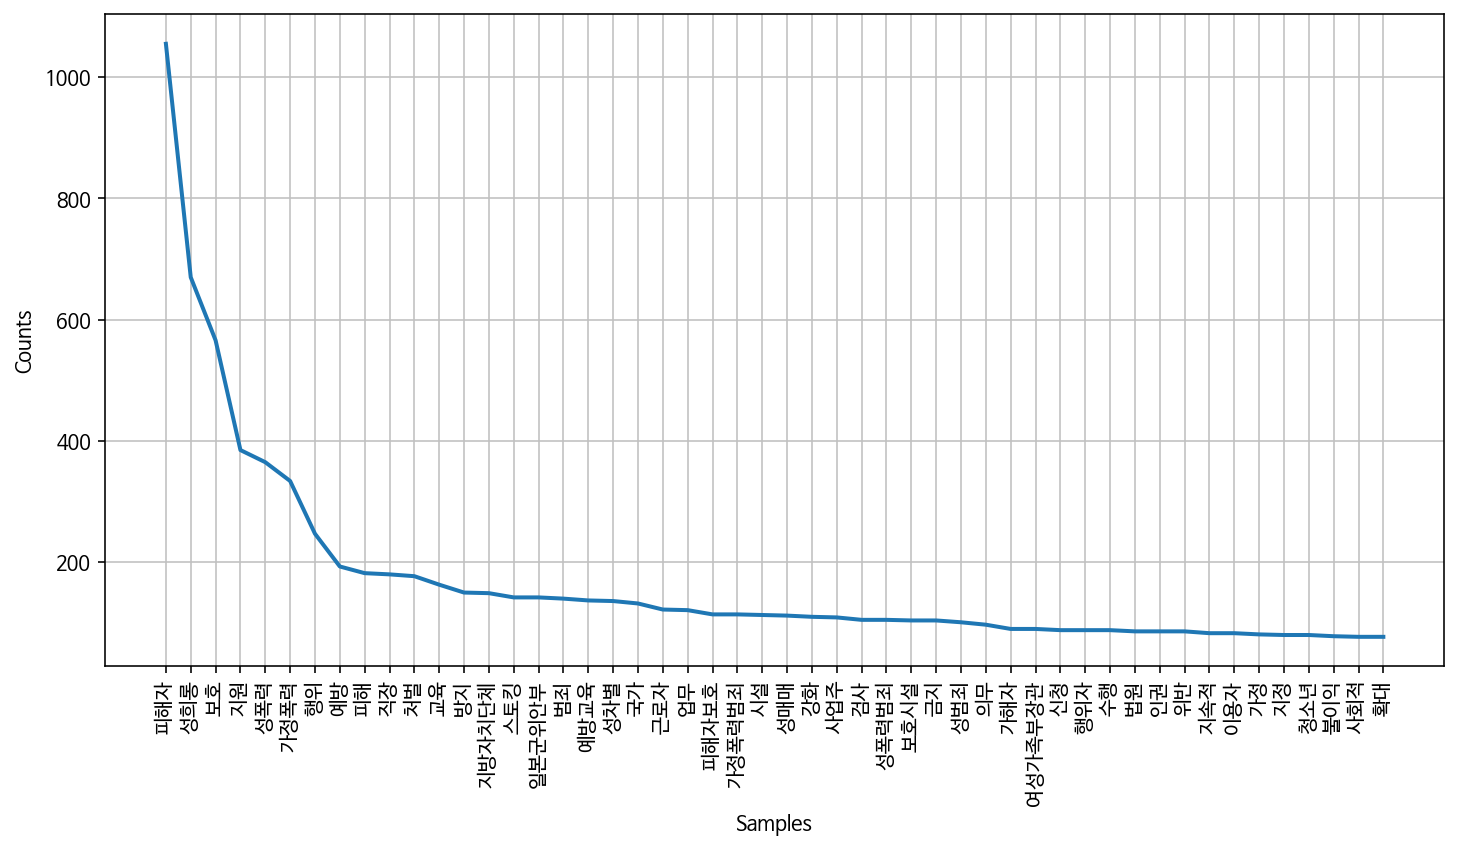

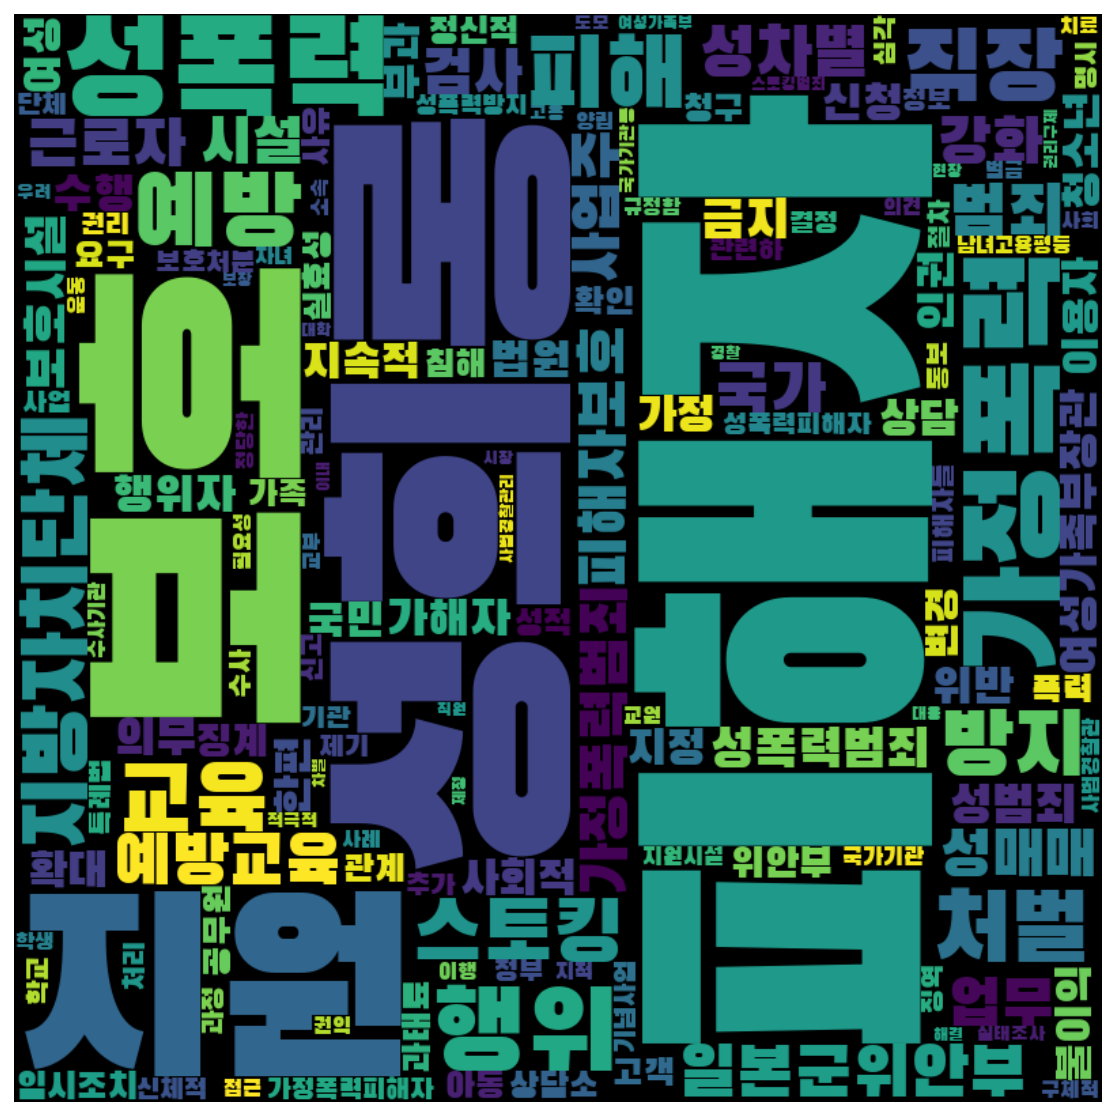

In [108]:
frewords_vis(progressive_g3_tokens)
wordcloud_vis(progressive_g3_tokens)

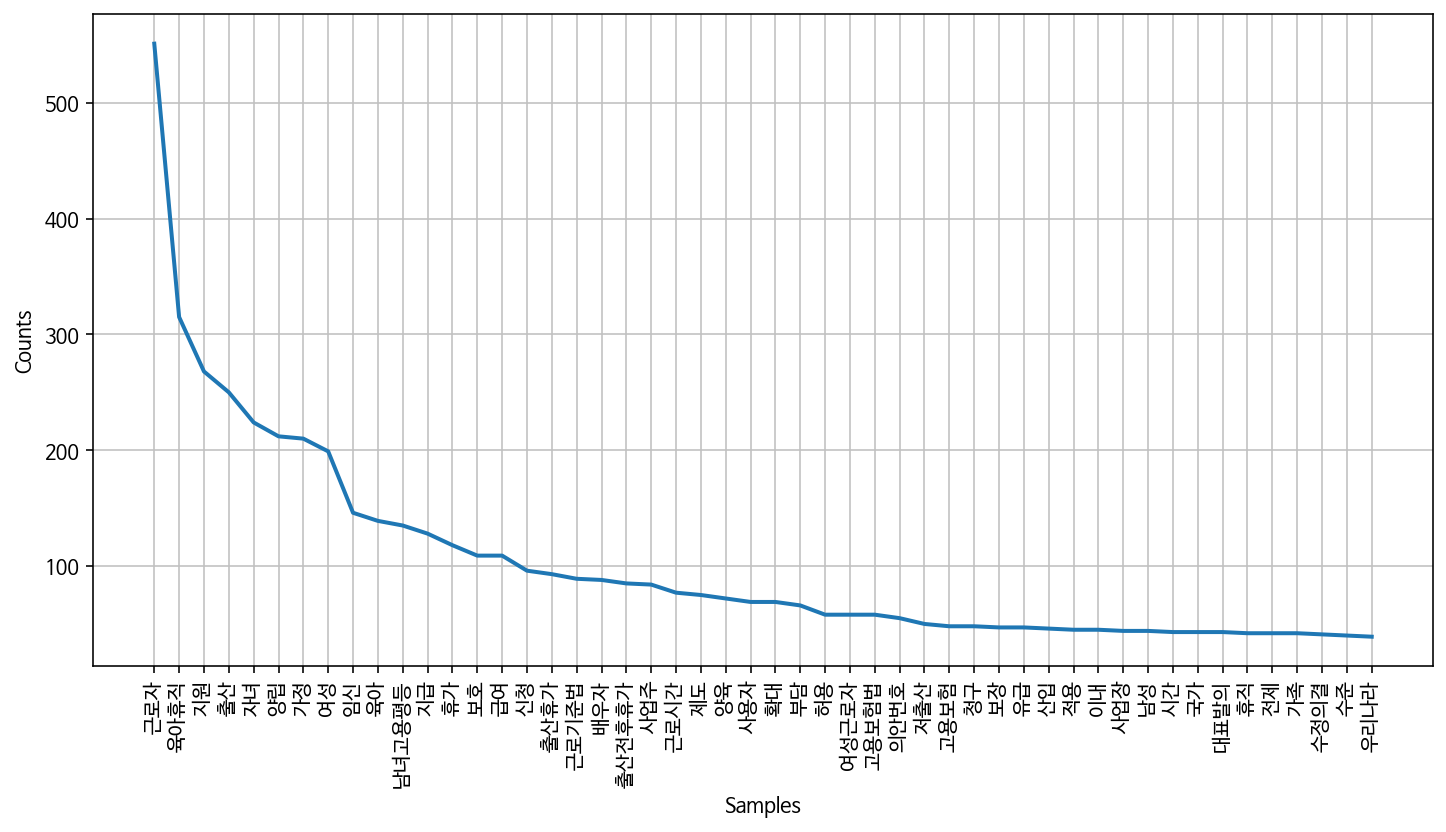

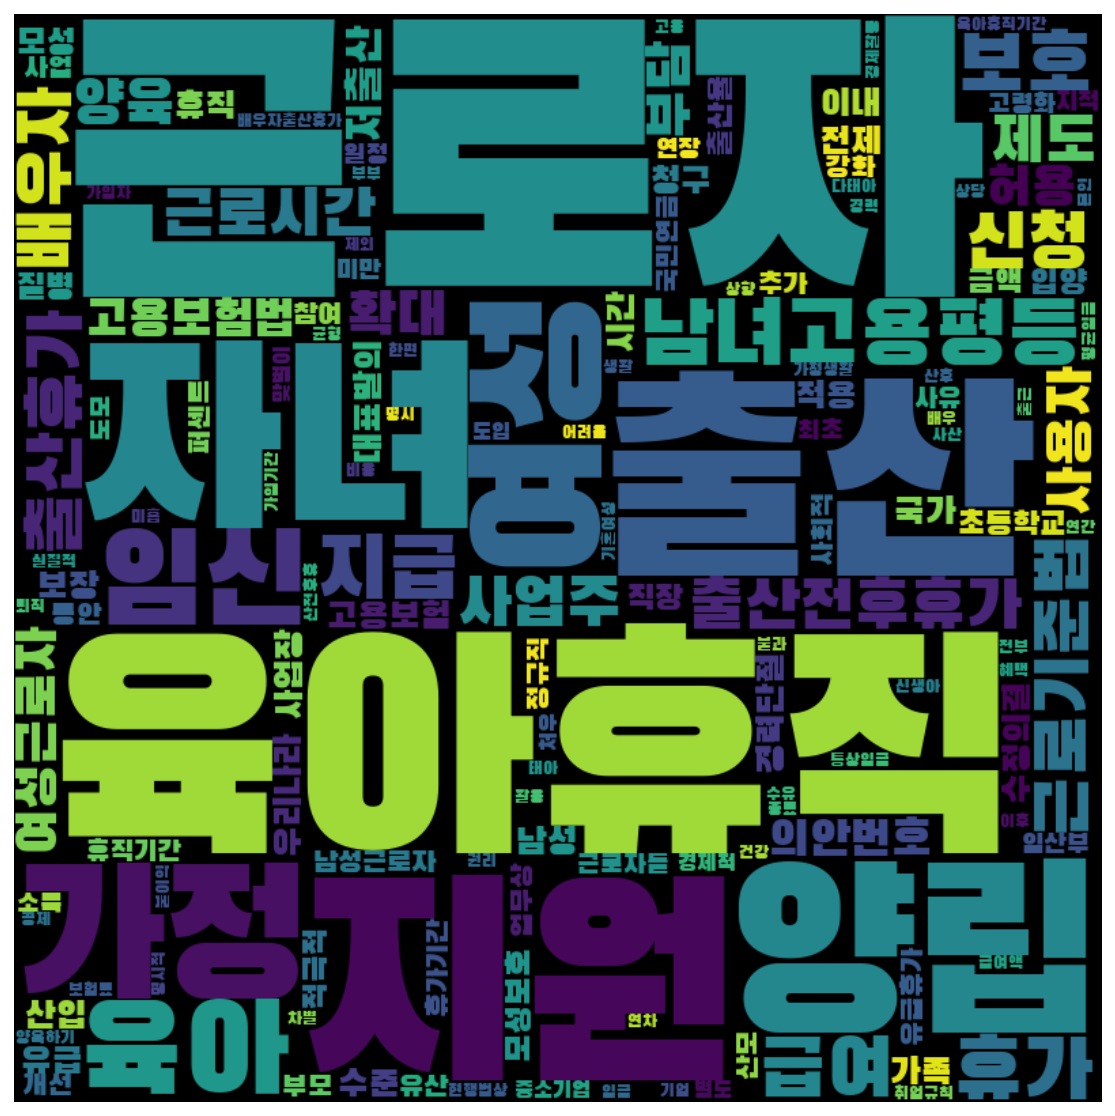

In [109]:
frewords_vis(progressive_g4_tokens)
wordcloud_vis(progressive_g4_tokens)

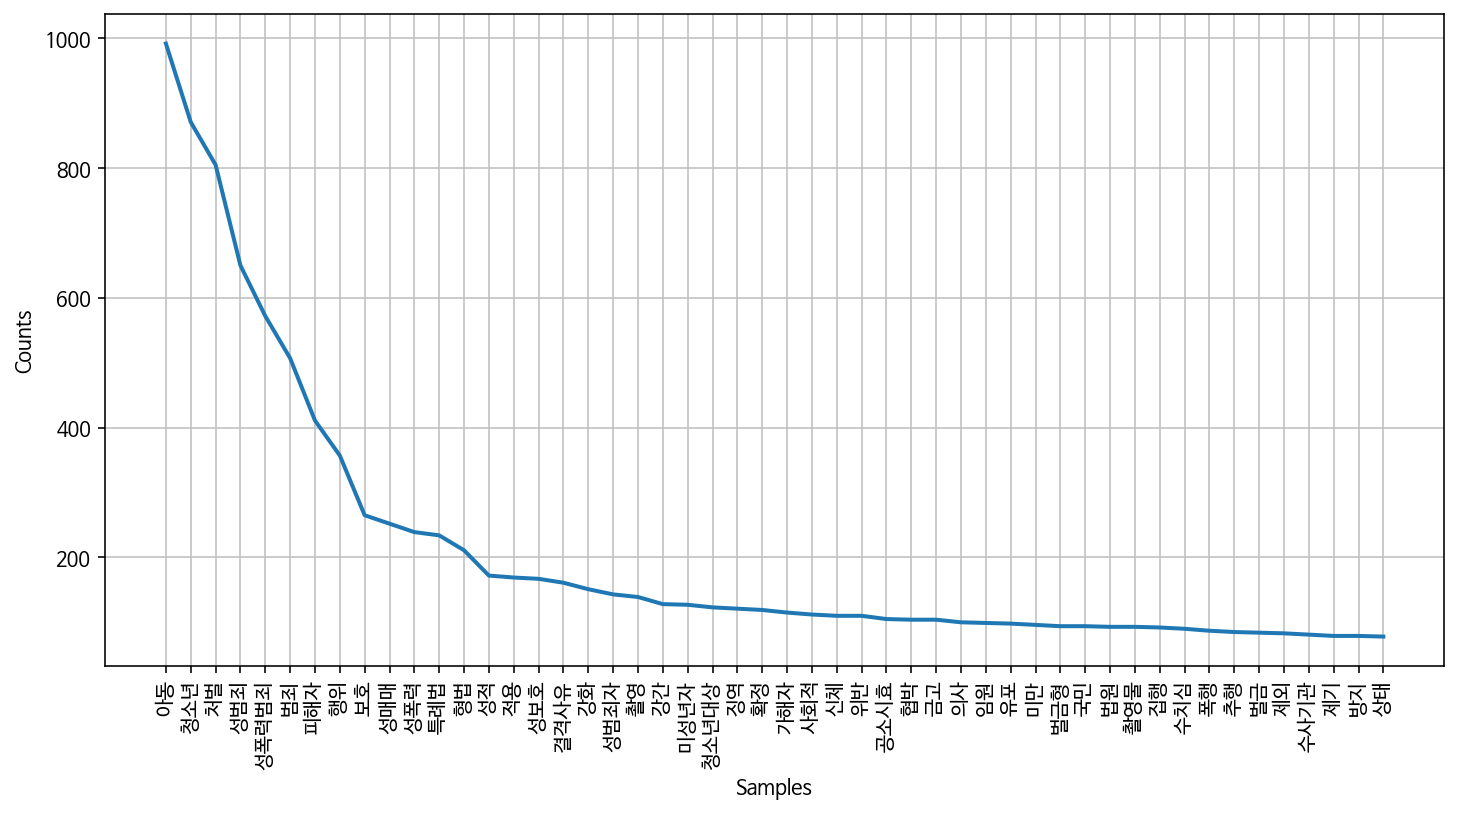

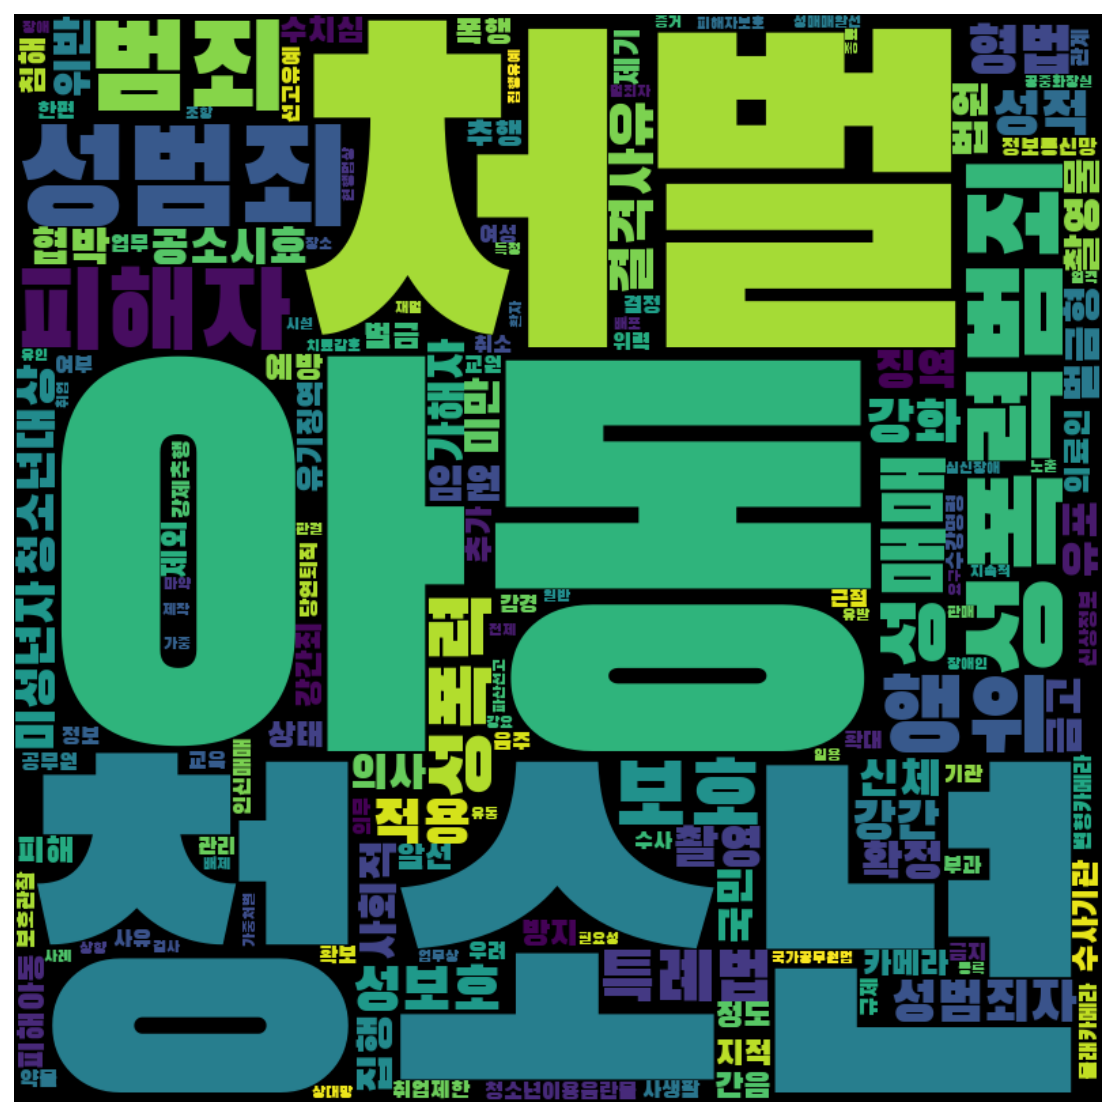

In [110]:
frewords_vis(progressive_g5_tokens)
wordcloud_vis(progressive_g5_tokens)

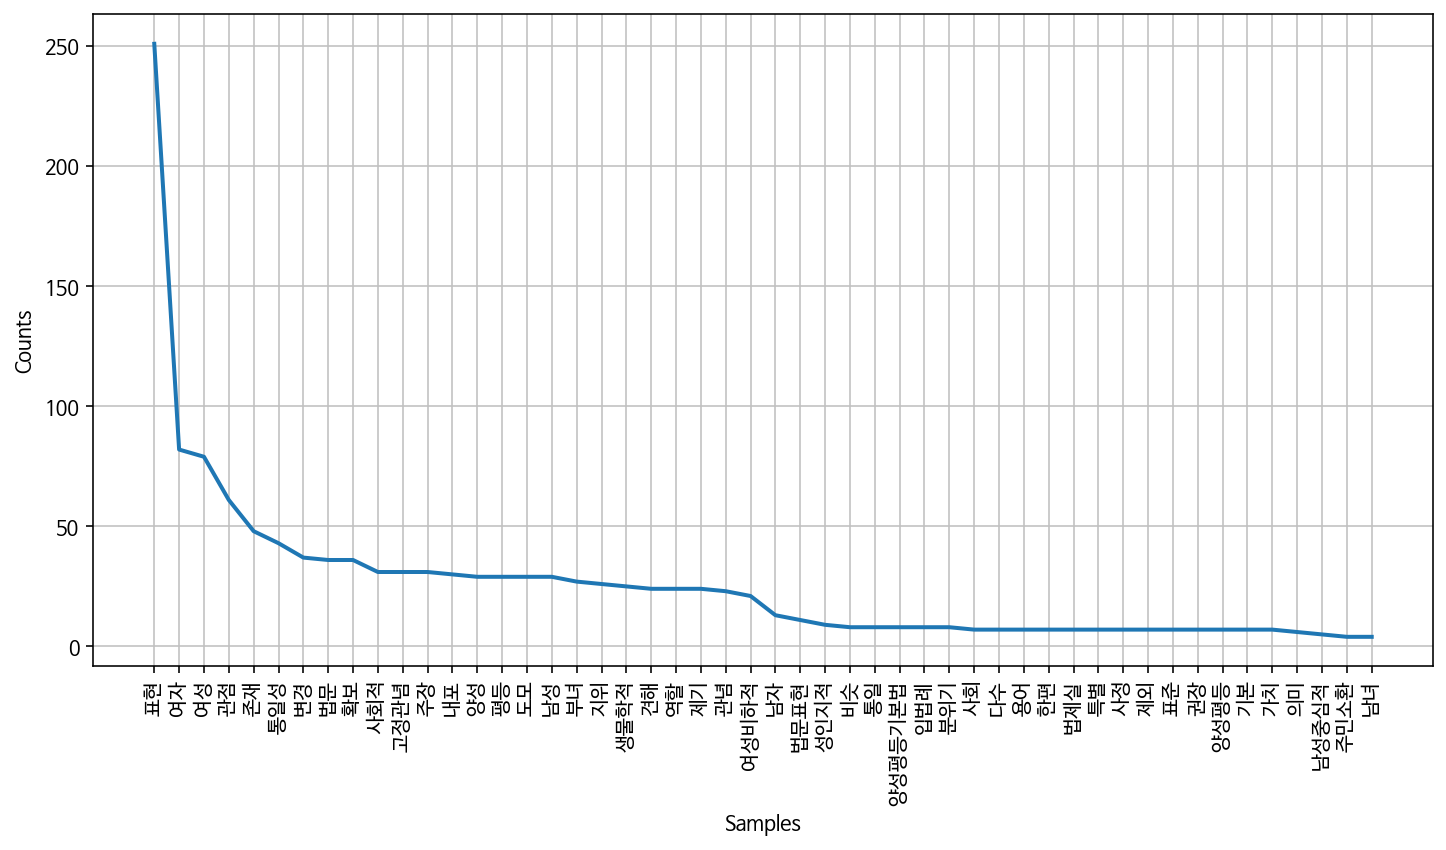

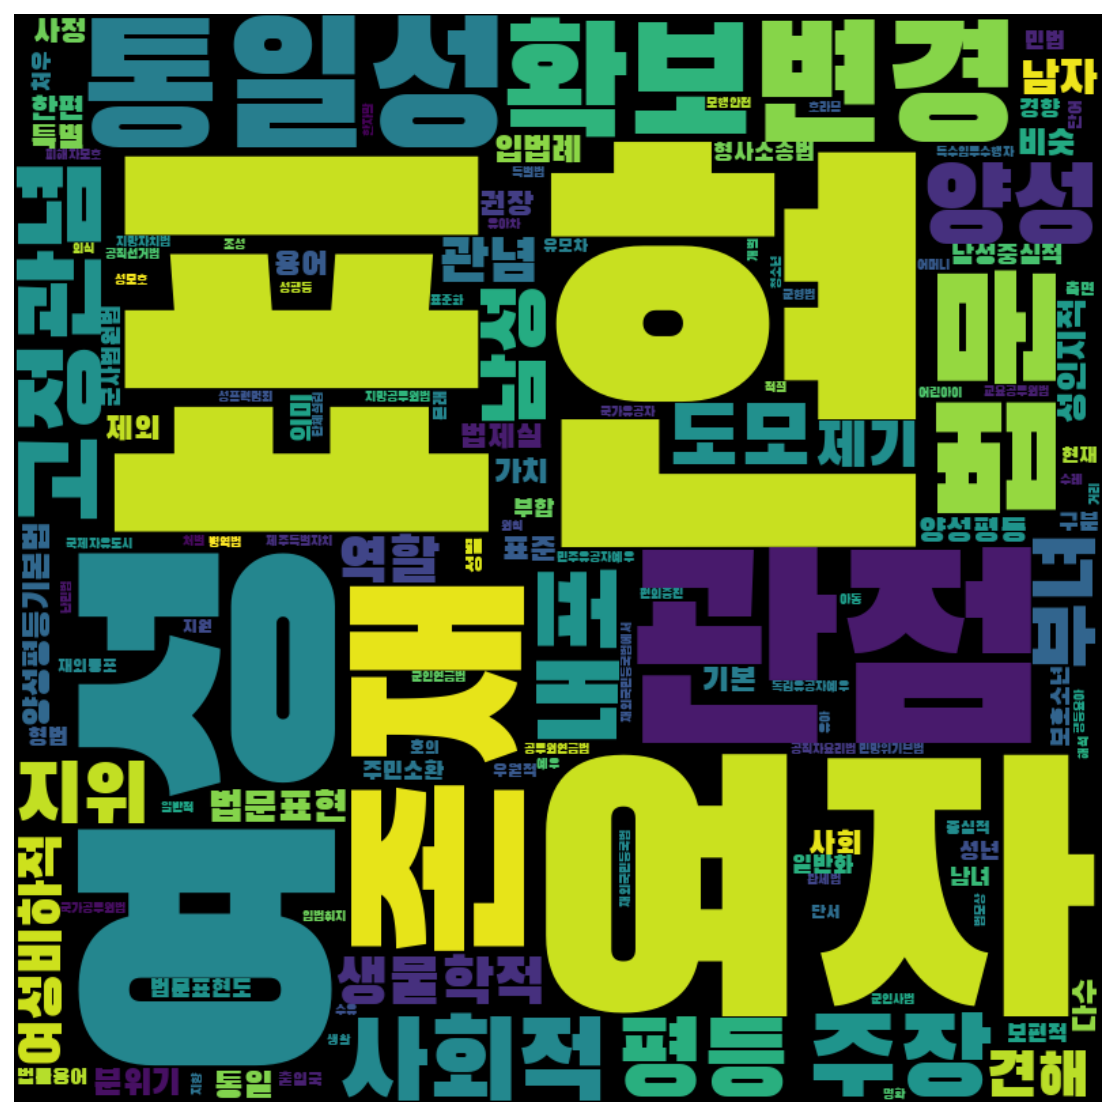

In [111]:
frewords_vis(progressive_g6_tokens)
wordcloud_vis(progressive_g6_tokens)

## 보수 k-means

엘보우: 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]


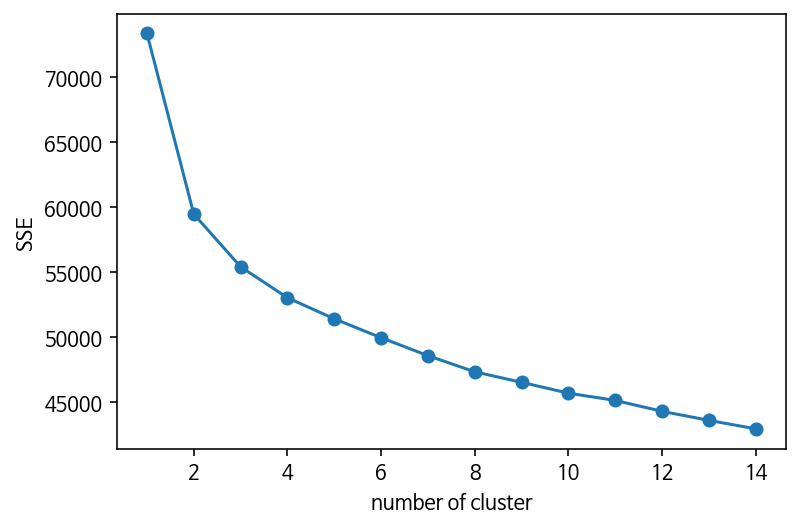

In [112]:
word_vectors_con = conservative['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors_con)

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


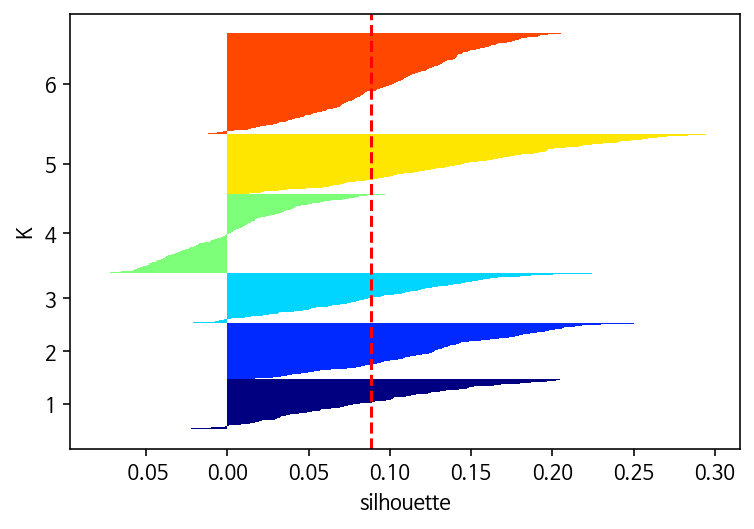

In [113]:
word_vectors_con = conservative['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors_con)
plotSilhouette(word_vectors_con, y_km)

In [115]:
# K means 수행 
word_vectors_con = conservative['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors_con)
conservative['category'] = idx

<ipython-input-115-413f37cc3da8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conservative['category'] = idx


In [116]:
conservative['category'].value_counts()

3    427
1    279
4    246
2    219
0    194
5    189
Name: category, dtype: int64

In [117]:
conservative_g1 = conservative[conservative['category'] == 0]
conservative_g2 = conservative[conservative['category'] == 1]
conservative_g3 = conservative[conservative['category'] == 2]
conservative_g4 = conservative[conservative['category'] == 3]
conservative_g5 = conservative[conservative['category'] == 4]
conservative_g6 = conservative[conservative['category'] == 5]

In [118]:
conservative_g1_tokens = total_tokens(conservative_g1['tokens'])
conservative_g2_tokens = total_tokens(conservative_g2['tokens'])
conservative_g3_tokens = total_tokens(conservative_g3['tokens'])
conservative_g4_tokens = total_tokens(conservative_g4['tokens'])
conservative_g5_tokens = total_tokens(conservative_g5['tokens'])
conservative_g6_tokens = total_tokens(conservative_g6['tokens'])

In [119]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출','신설',
            '신설','대상','문제','제공','항제','사용','근거','불구','범위','이유','증가']
conservative_g1_tokens = [each_word for each_word in conservative_g1_tokens if each_word not in stopwords]
conservative_g2_tokens = [each_word for each_word in conservative_g2_tokens if each_word not in stopwords]
conservative_g3_tokens = [each_word for each_word in conservative_g3_tokens if each_word not in stopwords]
conservative_g4_tokens = [each_word for each_word in conservative_g4_tokens if each_word not in stopwords]
conservative_g5_tokens = [each_word for each_word in conservative_g5_tokens if each_word not in stopwords]
conservative_g6_tokens = [each_word for each_word in conservative_g6_tokens if each_word not in stopwords]

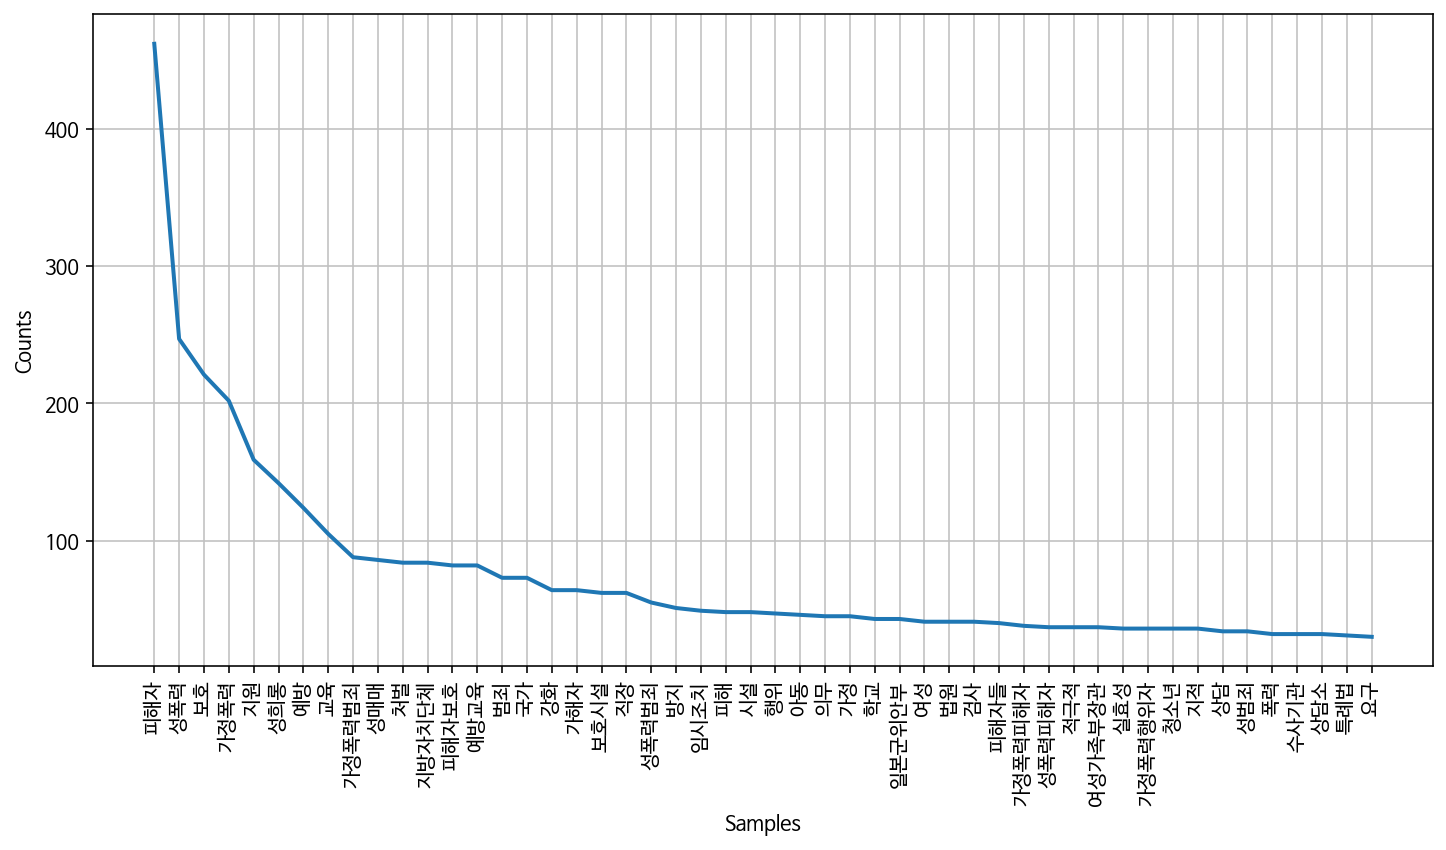

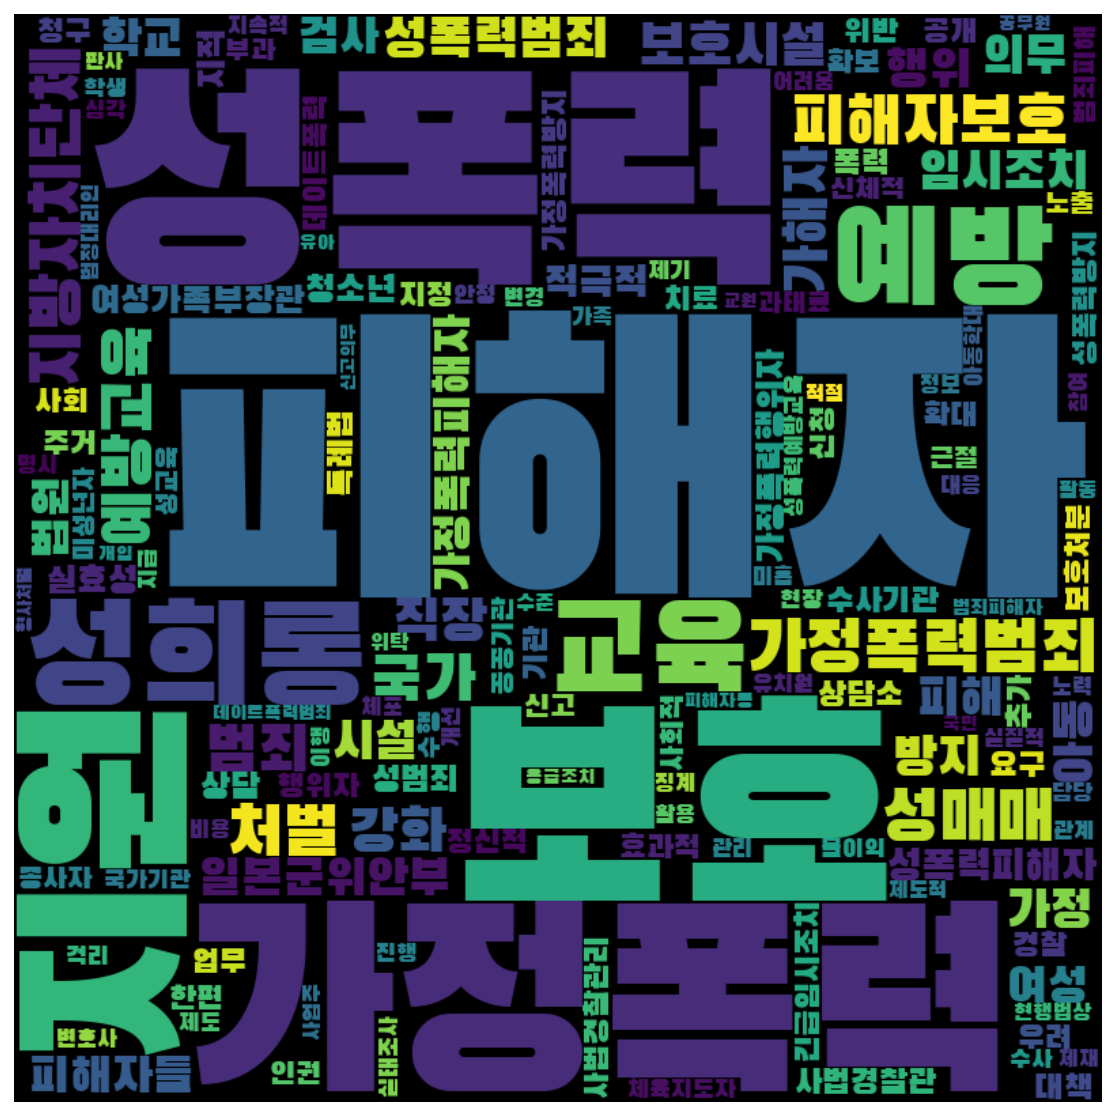

In [120]:
frewords_vis(conservative_g1_tokens)
wordcloud_vis(conservative_g1_tokens)

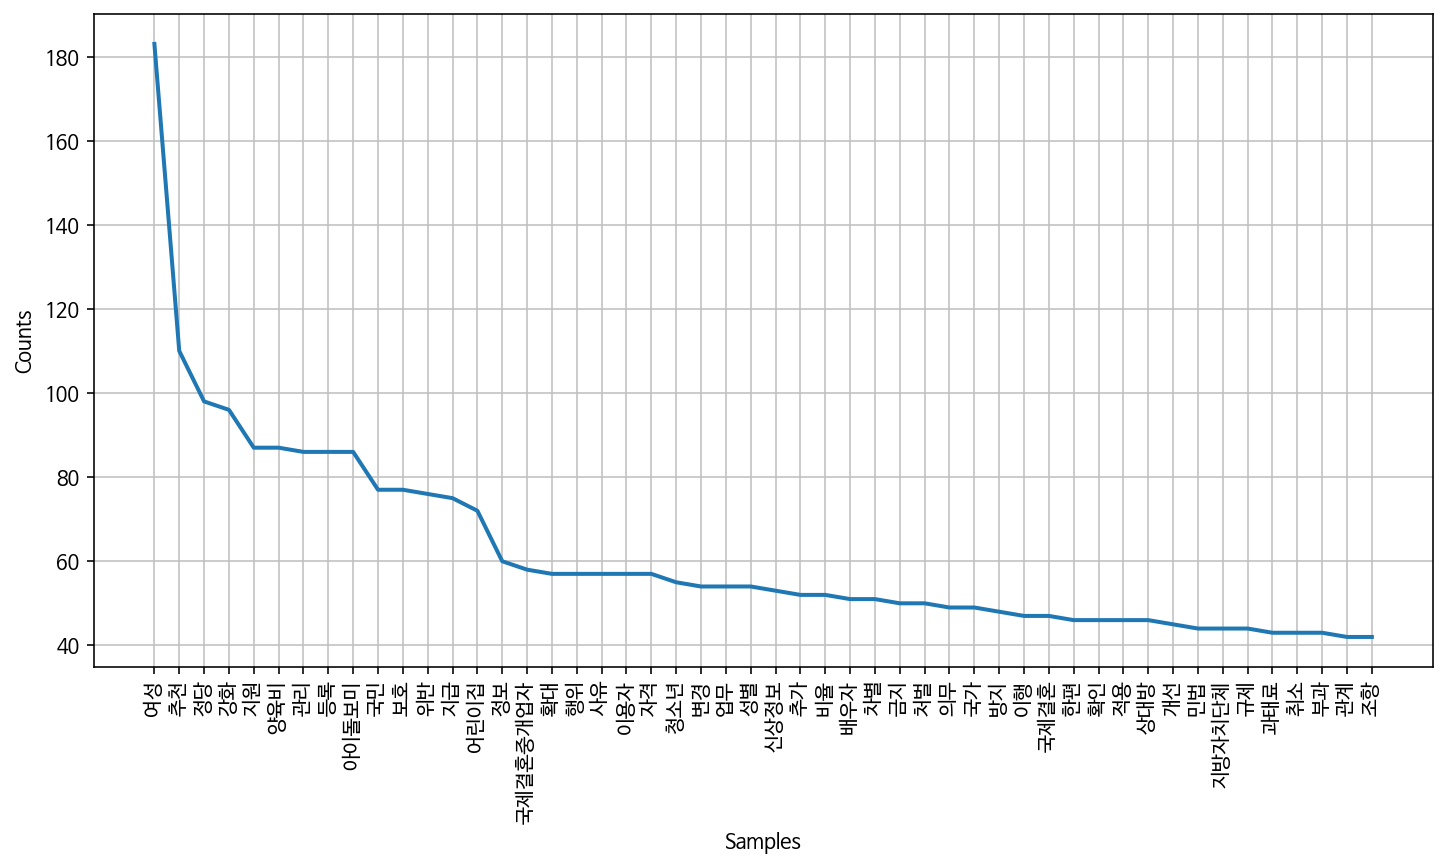

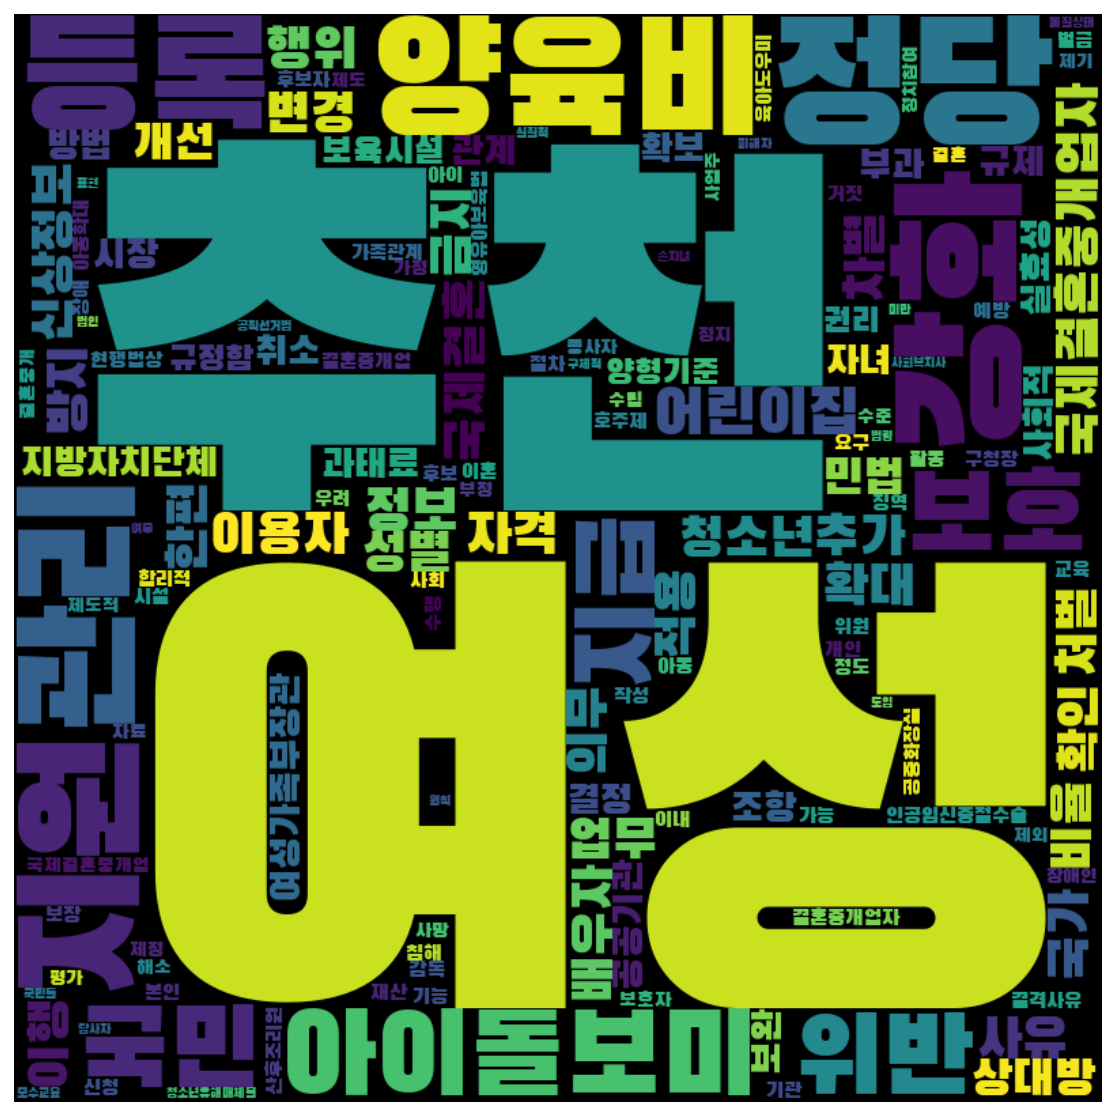

In [121]:
frewords_vis(conservative_g2_tokens)
wordcloud_vis(conservative_g2_tokens)

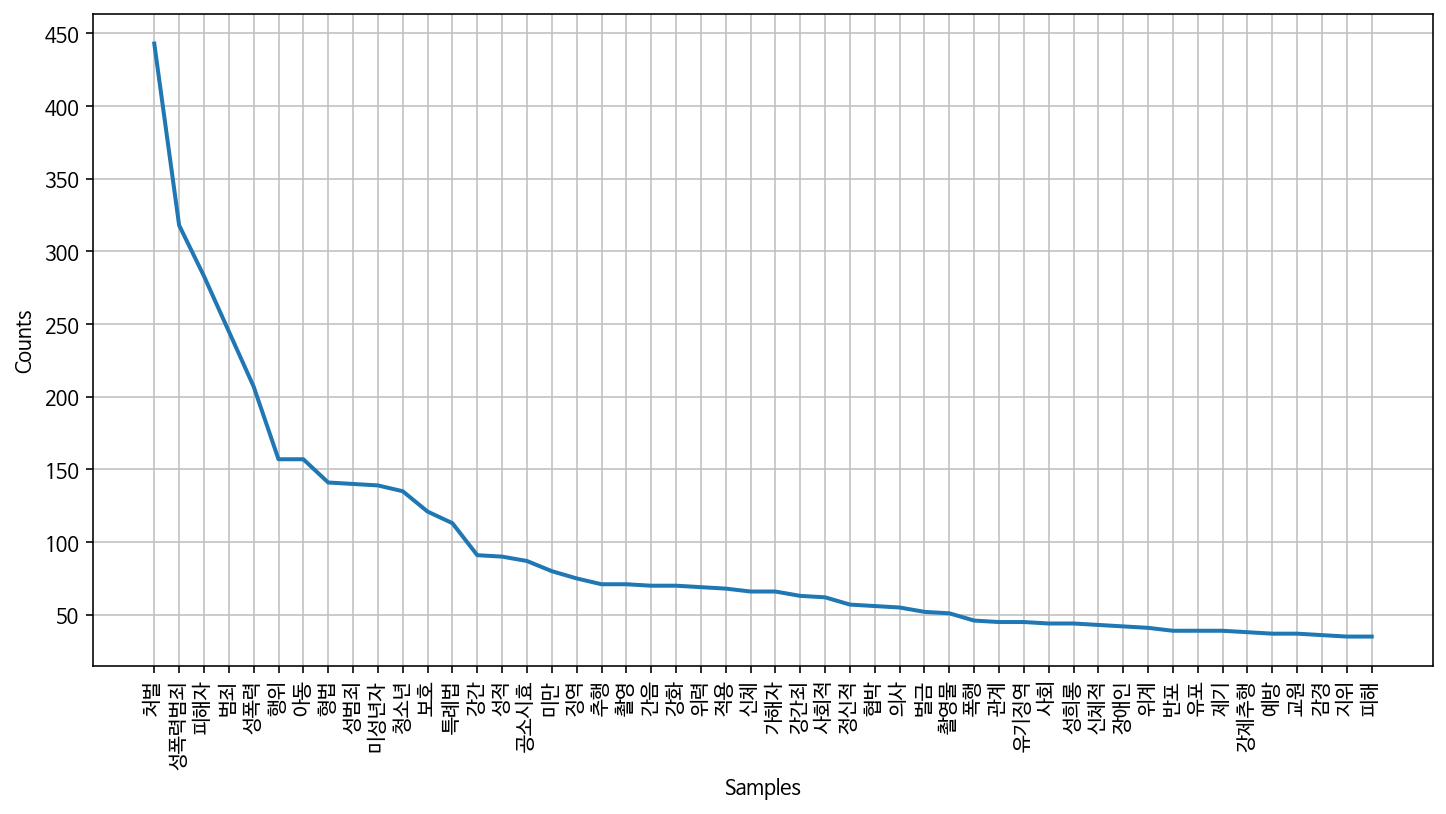

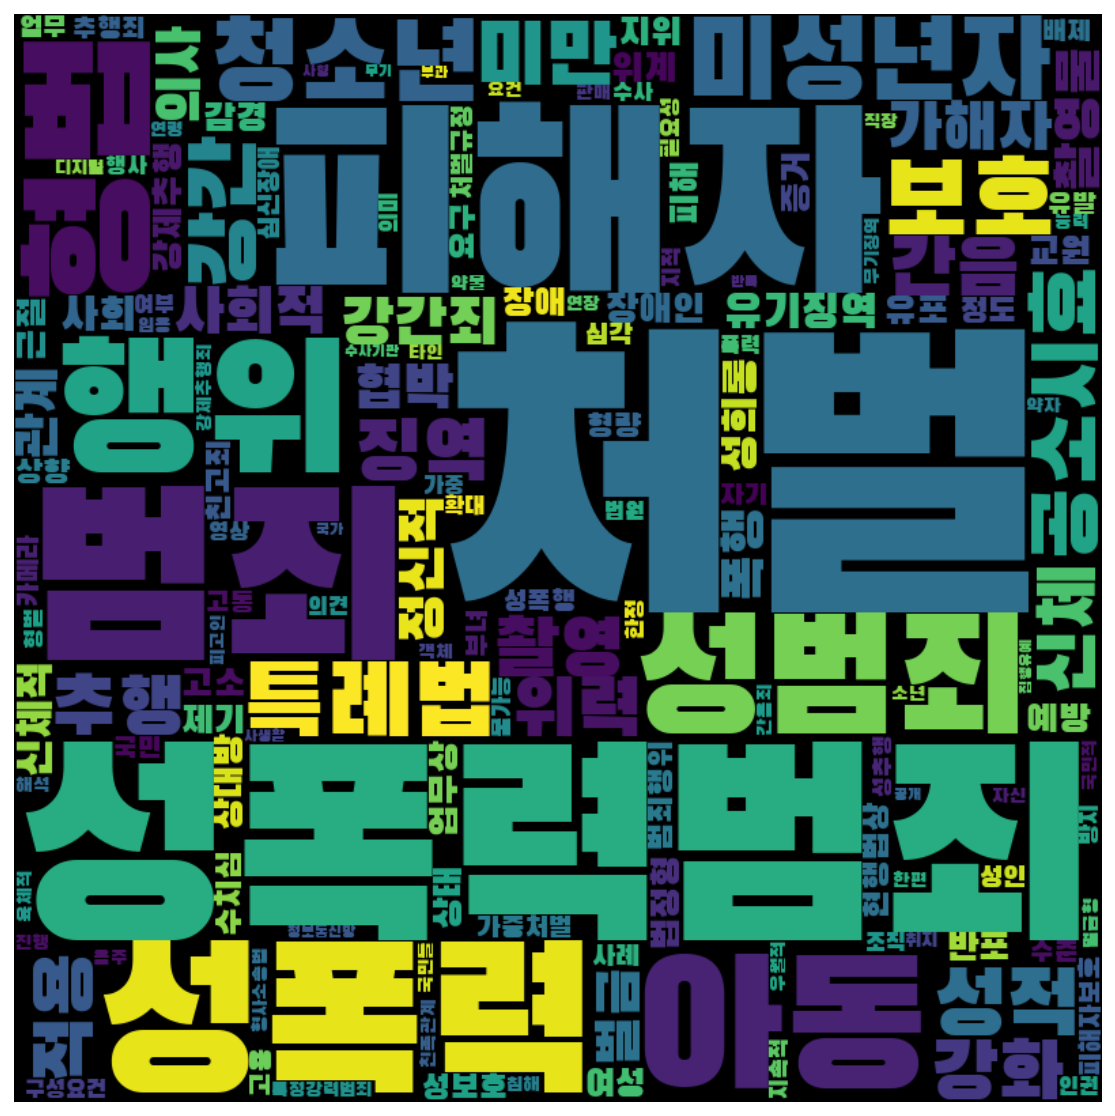

In [122]:
frewords_vis(conservative_g3_tokens)
wordcloud_vis(conservative_g3_tokens)

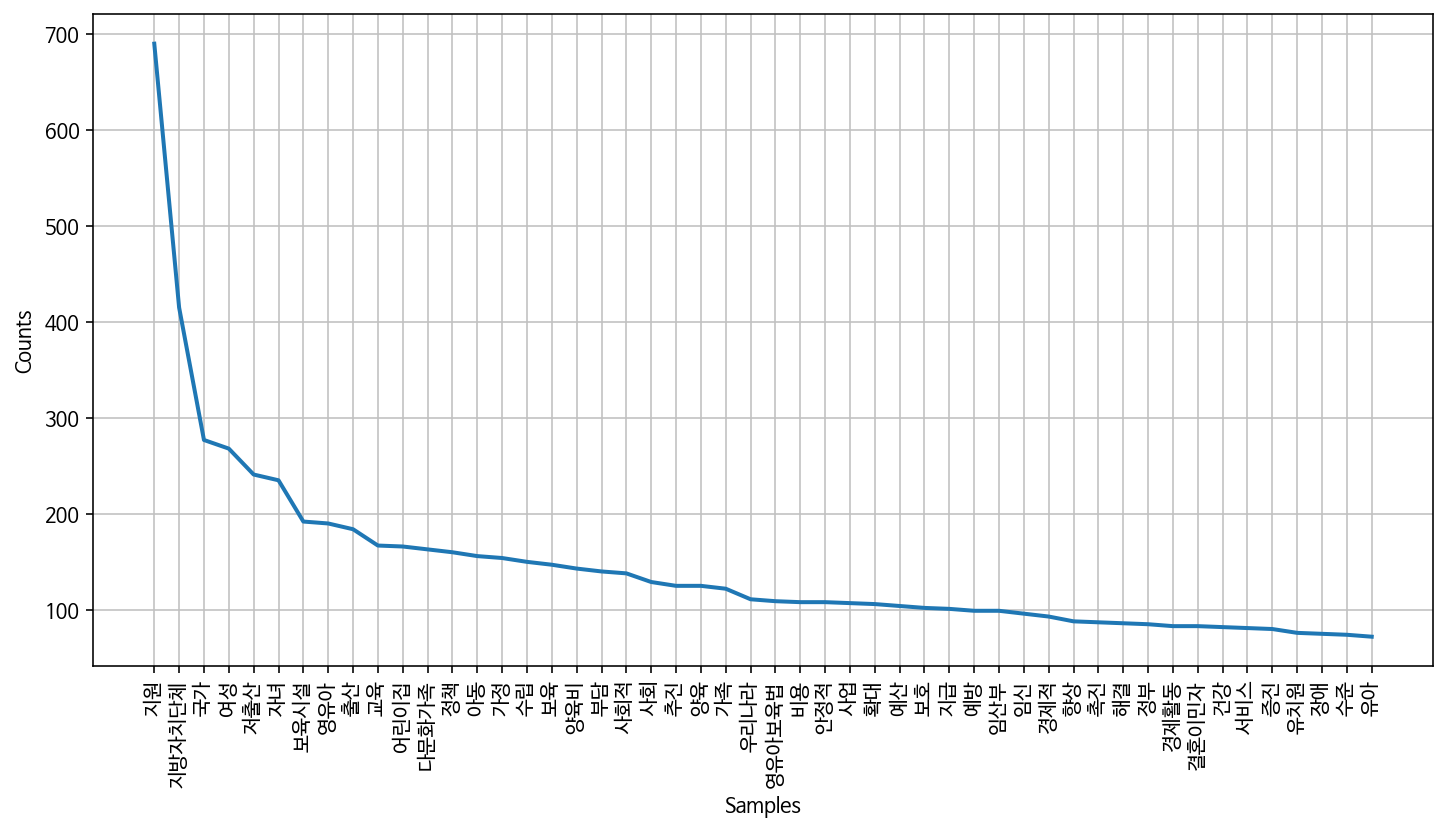

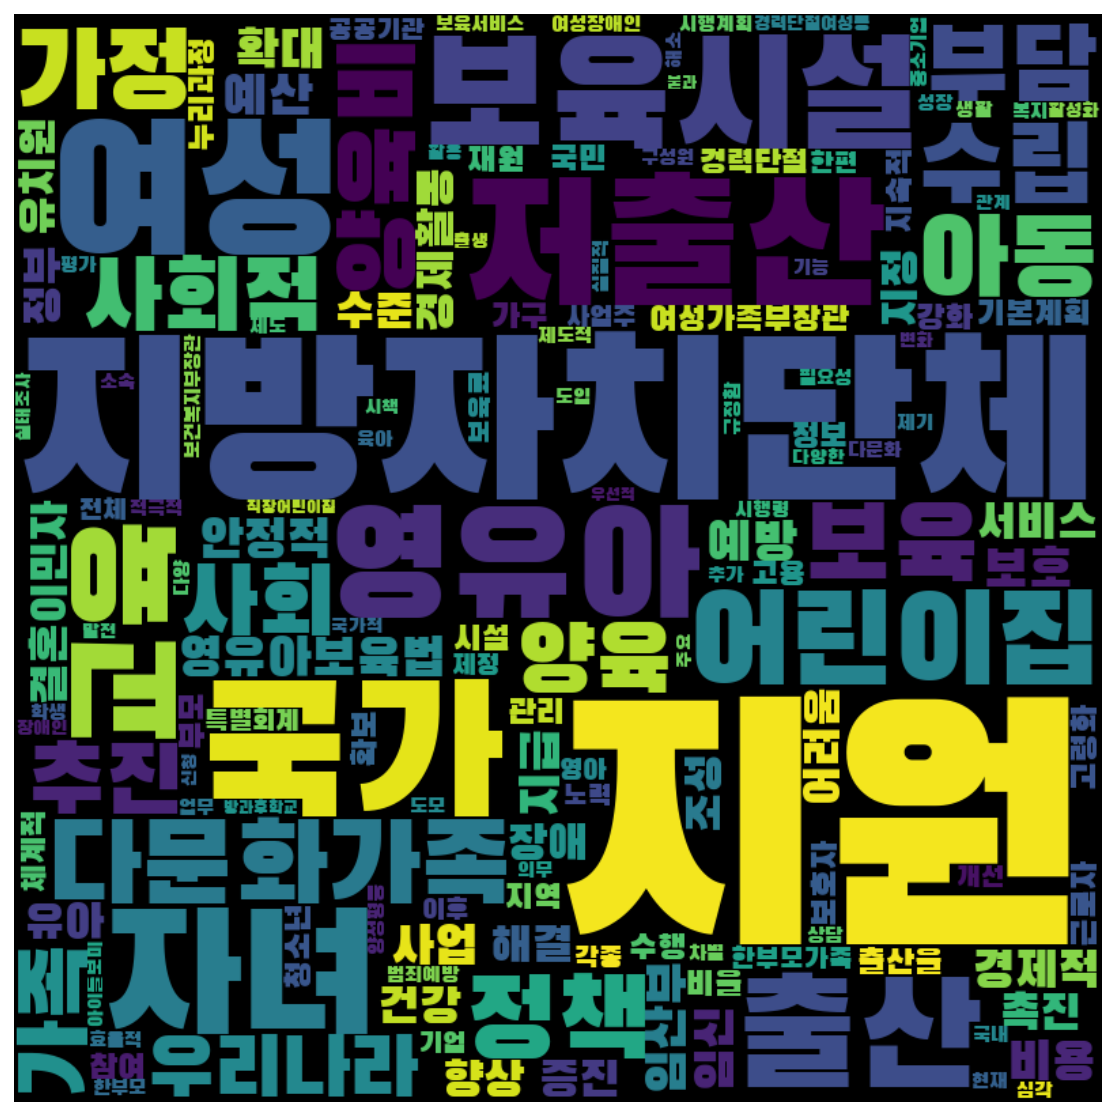

In [123]:
frewords_vis(conservative_g4_tokens)
wordcloud_vis(conservative_g4_tokens)

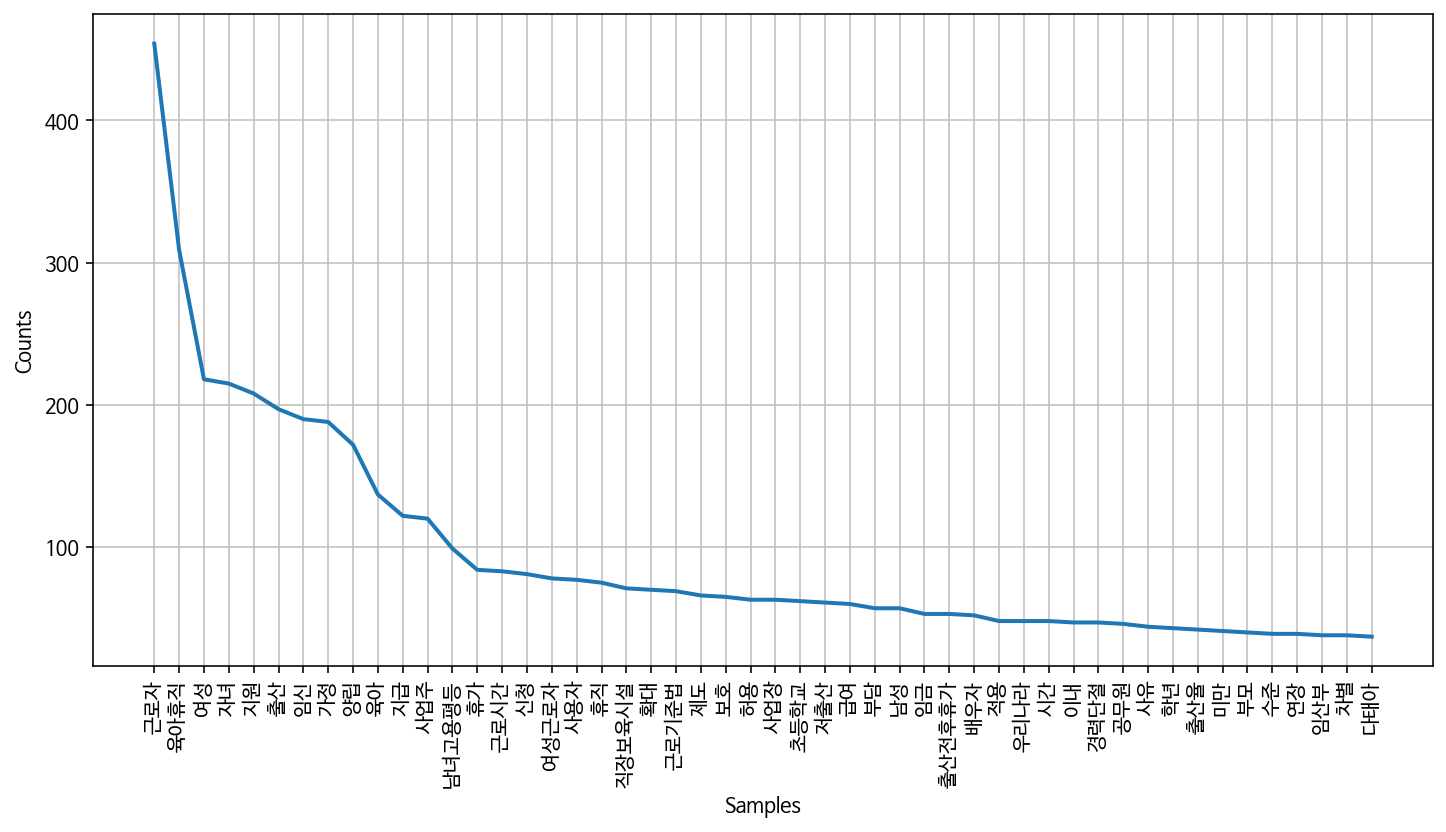

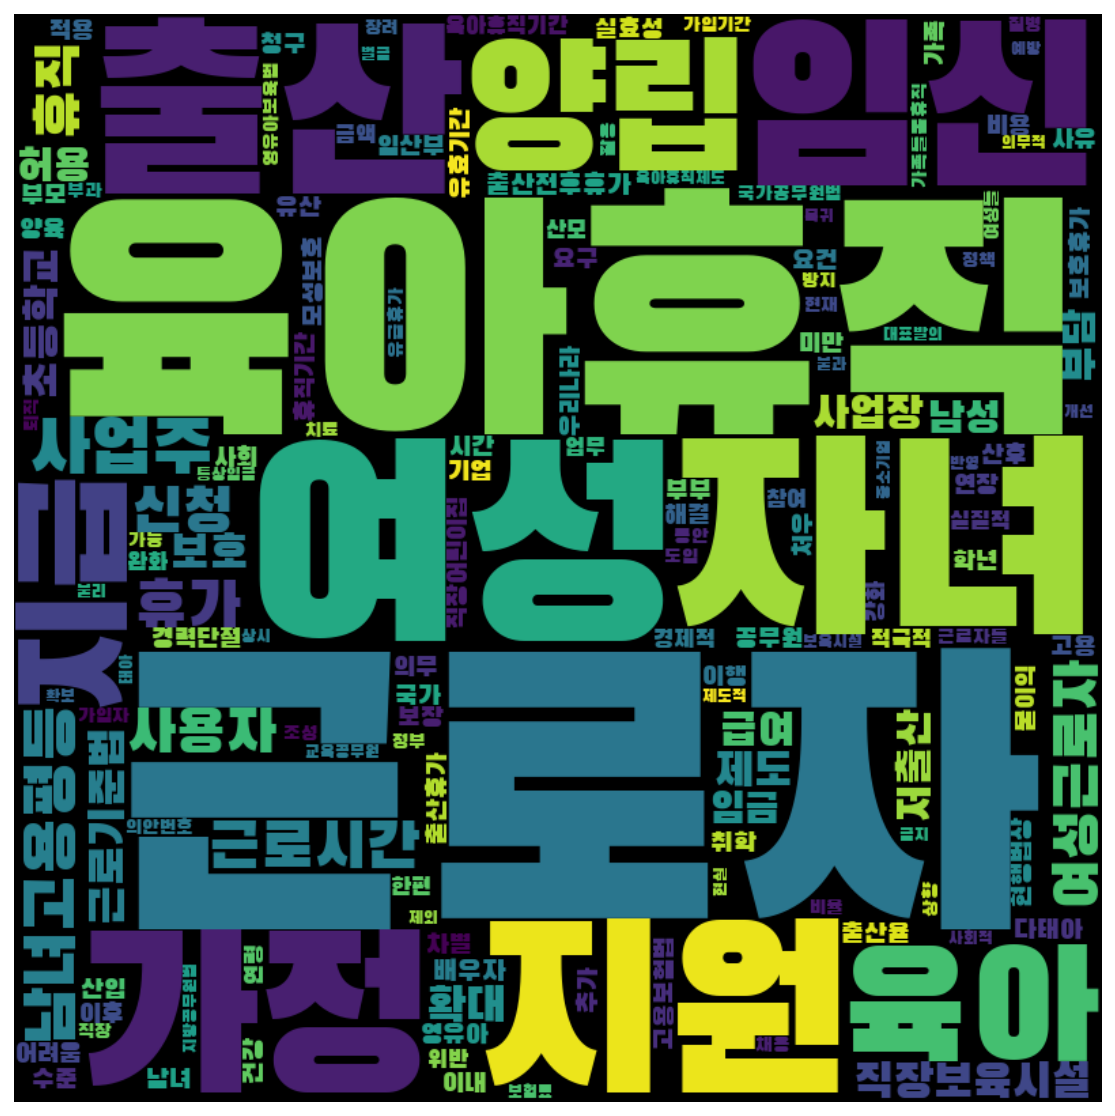

In [124]:
frewords_vis(conservative_g5_tokens)
wordcloud_vis(conservative_g5_tokens)

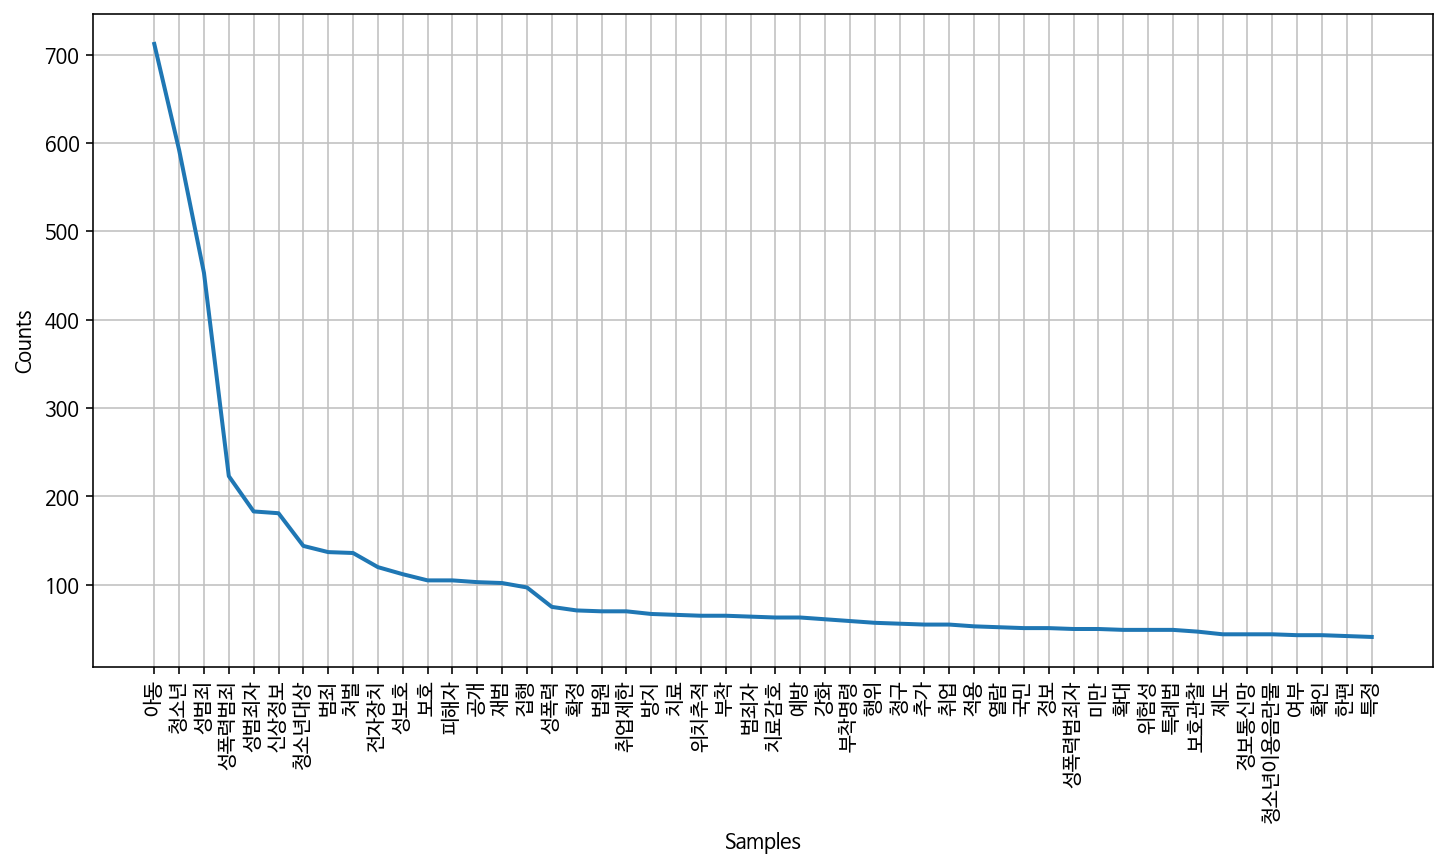

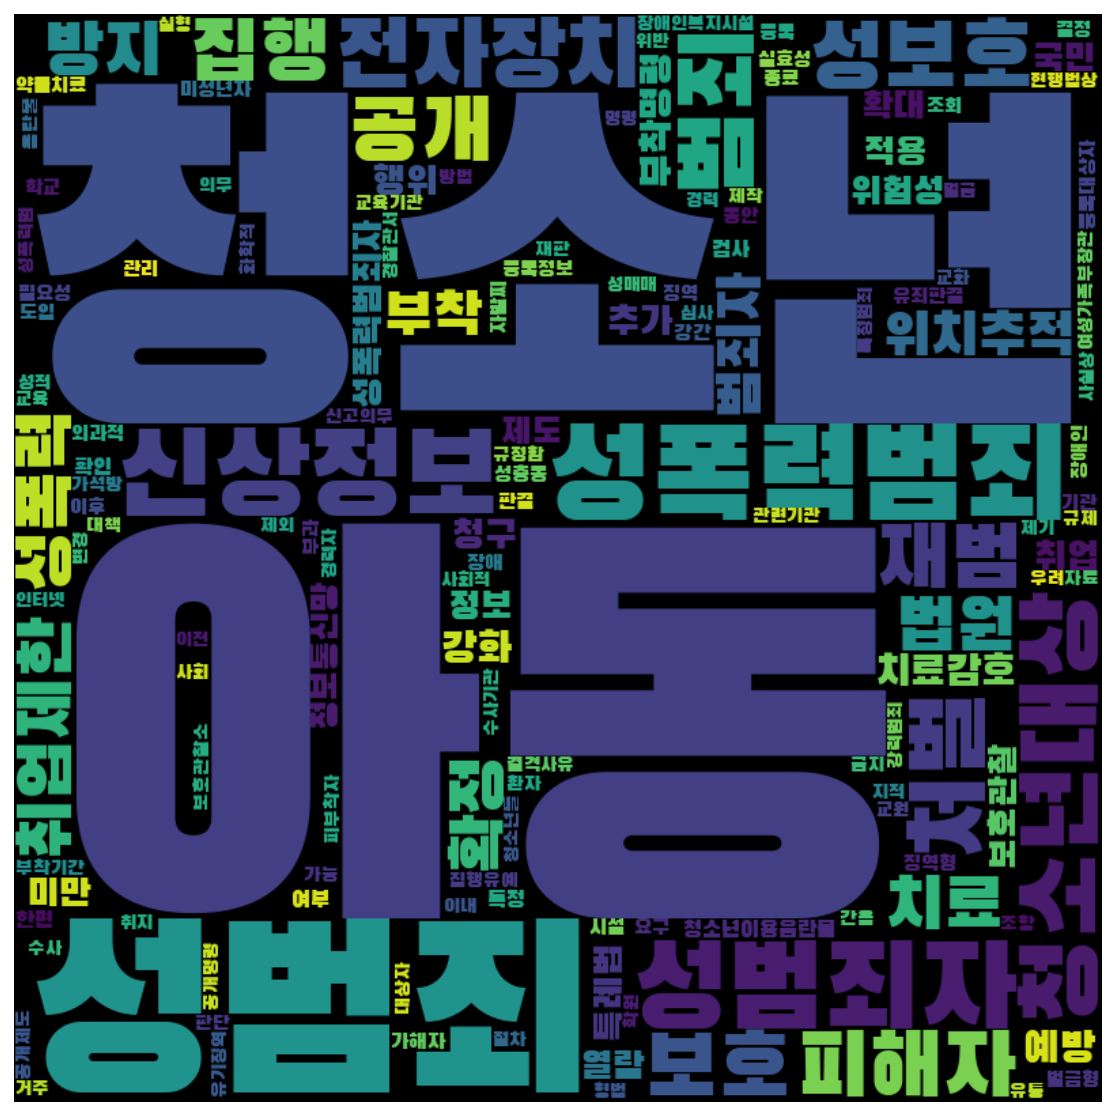

In [125]:
frewords_vis(conservative_g6_tokens)
wordcloud_vis(conservative_g6_tokens)